 HMM(Hidden Markov Model)과 Viterbi 알고리즘을 설명하고 HMM 기반 화음 인식 방법과 그 예를 다룬다.

> 이 글은 [FMP(Fundamentals of Music Processing) Notebooks](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html)을 참고로 합니다.

In [2]:
import numpy as np
import pandas as pd
import IPython.display as ipd
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
from scipy.linalg import circulant

from utils.chord_tools import compute_chromagram_from_filename, chord_recognition_template, get_chord_labels, convert_chord_ann_matrix
from utils.chord_tools import compute_eval_measures, plot_matrix_chord_eval
from utils.plot_tools import *

# Hidden Markov Model (HMM)

## Markov Chains

- 한 화음에서 다른 화음으로의 전환은 어느 한 특정 전환이 다른 전환보다 일어날 가능성이 더 높다. 이러한 우도(likelihood)를 포착하기 위해 **마코프 체인(Markov chains)** 이라는 개념을 사용할 수 있다. 

- 화음 인식 시나리오에서 고려할 화음 유형이 집합으로 표현된다고 가정하자.
$$\mathcal{A}:=\{\alpha_{1},\alpha_{2},\ldots,\alpha_{I}\}$$ 
of size $I\in\mathbb{N}$

- 원소 $\alpha_{i}$ for $i\in[1:I]$ 는 **상태**(state)라고 한다. 화음의 진행은 어떤 state $s_{n}\in\mathcal{A}$에 있는 것으로, 어느 시간 $n=1,2,3,\ldots$로 설명될 수 있는 시스템에 의해 실현된다. 한 상태에서 다른 상태로의 변경은 각 state와 관련된 확률 집합에 따라 지정된다. 일반적으로 그러한 시스템의 확률적 설명은 매우 복잡할 수 있다. 

- 모델을 단순화하기 위해 현재 상태 $s_{n}$에서 다음 상태 $s_{n+1}$로 변경될 확률은 그보다 앞선 이벤트가 아닌 현재 state에만 의존한다고 가정한다.

- 조건부 확률로 이 속성을 표현하면 다음과 같다.
$$P[s_{n+1}=\alpha_{j}|s_{n}=\alpha_{i},s_{n-1}=\alpha_{k},\ldots]
     = P[s_{n+1}=\alpha_{j}|s_{n}=\alpha_{i}]$$

- 이러한 "기억상실"을 **마코프 속성(Markov property)** 이라고 한다.

- 이 속성 외에도 시스템이 **시간 이동 하에서 불변**이라고 가정하는 경우가 많으며, 이는 정의에 따라 다음 계수가 인덱스 $n$과 독립적이 된다는 것을 의미한다:
$$a_{ij} := P[s_{n+1}=\alpha_{j} | s_{n}=\alpha_{i}] \in [0,1]$$
for $i,j\in[1:I]$

- 이러한 계수는 **상태 전이 확률(state transition probabilities)** 이라고도 한다. 상태 전이 확률은 표준 확률적 제약 조건 $\sum_{j=1}^{I} a_{ij} = 1$를 따르고 $(I\times I)$ 행렬로 표현할 수 있으며 $A$로 표시한다. 이러한 특성을 만족하는 시스템을 (이산 시간) **마코프 체인**이라고 한다. 

- 다음 그림은 이러한 정의를 보여준다. 장(major)화음 $\mathbf{C}$, $\mathbf{G}$, $\mathbf{F}$에 해당하는 $I=3$ 상태 $\alpha_{1}$, $\alpha_{2}$, $\alpha_{3}$로 구성된 Markov 체인을 정의한다. 그래프 표현에서 상태는 노드(node), 에지(edge)로의 전이 및 에지에 부착된 라벨로의 전이 확률에 해당한다.
    - 예를 들어 $\alpha_{1}=\mathbf{C}$ state를 유지할 전이 확률은 $a_{11}=0.8$인 반면, $\alpha_{1}=\ mathbf{C}$에서 $\alpha_{2}=\mathbf{G}$로 바뀔 전이 확률은 $a_{12}=0.1$이다.

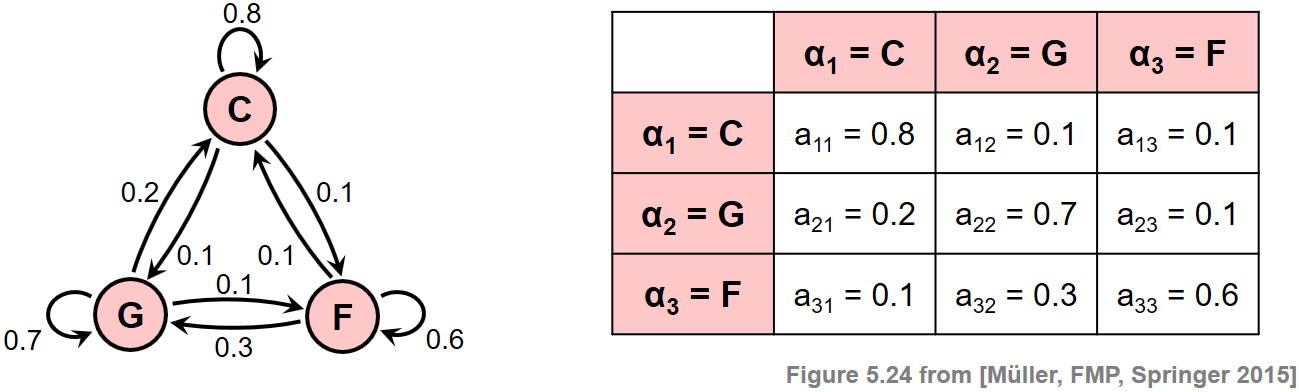

In [4]:
ipd.Image("../img/6.chord_recognition/FMP_C5_F24.png",width=700)

- 모델은 가능한 모든 화음 변화의 확률을 표현한다. 주어진 화음 진행의 확률을 계산하려면 모델이 시작되는 방법에 대한 정보도 필요하다. 이 정보는 **초기 상태 확률(initial state probabilities)** 이라는 추가 모델 매개변수에 의해 지정된다. 일반적인 Markov 체인의 경우 이러한 확률은 숫자로 지정된다.
$$c_{i} := P[s_{1}=\alpha_{i}] \in [0,1]$$
for $i\in[1:I]$

- 합이 1이 되는 이러한 계수는 길이 $I$의 $C$로 표시되는 벡터로 표현될 수 있다.

## Hidden Markov Models

- Markov 체인을 기반으로 상태 또는 화음 유형의 시퀀스로 구성된 주어진 관찰에 대해 확률을 계산할 수 있다. 그러나 화음 인식 시나리오에서 이것이 꼭 필요한 것은 아니다.

- 화음 유형의 시퀀스를 관찰하는 대신 화음 유형과 어떤 식으로든 관련된 **크로마 벡터 시퀀스**를 관찰할 수 있다. 즉, 상태 시퀀스가 직접적으로 보이지 않고, 상태 시퀀스를 기반으로 생성된 흐릿한 관찰 시퀀스만 존재한다.

- 이로 인해 Markov 체인이 **Hidden Markov 모델**(HMM)이라고 하는 통계 모델로 확장된다. 확률적 프레임워크를 사용하여 관찰된 특징 벡터와 화음 유형 사이의 관계를 나타내는 것이다. 각 상태는 특정 화음 유형이 특정 특징 벡터를 출력하거나 방출할 가능성을 나타내는 확률 함수를 갖추고 있다.

- 결과적으로 **hidden layer**와 **observable layer**로 구성된 2계층 프로세스를 얻는다. hidden layer은 관찰할 수 없는("숨겨진") 상태 시퀀스를 생성하지만, 상태-종속(state-dependent) 확률 함수를 기반으로 관찰 시퀀스를 생성한다.

- HMM의 **첫 번째 레이어**는 위에서 소개한 **마코프 체인**이다. 

- HMM의 두 번째 레이어를 정의하려면 가능한 출력 값의 공간과 각 상태에 대한 확률 함수를 지정해야 한다. 

- 일반적으로 출력 공간은 실수, 벡터 공간 또는 모든 종류의 특징 공간을 포함하는 모든 집합이 될 수 있다. 예를 들어, 화음 인식의 경우 이 공간은 가능한 모든 $12$ 차원의 크로마 벡터로 구성된 특징 공간 $\mathcal{F}=\mathbb{R}^{12}$으로 모델링될 수 있다.

- 단순화를 위해 출력 공간이 불연속적이고 유한한 것으로 가정되는 **이산(discrete) HMM**의 경우만 고려한다. 이 경우 공간을 유한 집합으로 모델링할 수 있다.
$$\mathcal{B} = \{\beta_{1},\beta_{2},\ldots,\beta_{K}\}$$
개별 출력 요소 $\beta_{k}$, $k\in[1:K]$로 구성된 $K\in\mathbb{N}$ 크기를 가지며, 이를 **관찰 기호(obeservation symbols)** 라고도 한다.

- HMM은 **방출(emission) 확률** 또는 **출력(output) 확률**이라고도 하는 확률 함수를 각 상태와 연결한다. 불연속적인 경우 방출 확률은 다음의 계수로 지정된다.
$$b_{ik}\in[0,1]$$
for $i\in[1:I]$ and $k\in[1:K]$
    
- 각 계수 $b_{ik}$는 상태 $\alpha_{i}$에 있을 때 관측 기호 $\beta_{k}$를 출력할 시스템의 확률을 나타낸다. 상태 전이 확률과 유사하게, 방출 확률은 확률적 제약 조건 $\sum_{k=1}^{K} \beta_{ik} = 1$ for $i\in[1:I]$를 충족하는 데 필요하다(따라서 각 상태에 대한 확률 분포 형성). 

- 계수는 $B$로 표시되는 $(I\times K)$ 행렬로 표현할 수 있다. 요약하면 HMM은 다음의 튜플로 지정된다.
$$\Theta:=(\mathcal{A},A,C,\mathcal{B},B)$$

- $\mathcal{A}$ 및 $\mathcal{B}$ 집합은 일반적으로 모델의 고정 구성 요소로 간주되는 반면, $A$, $B$ 및 $C$로 지정된 확률 값은 결정할 수 이쓴 매개변수이다. 이는 전문가 자신의 음악 지식 혹은 적절하게 라벨링된 교육 데이터를 기반으로 한 학습 절차를 사용하여 수행할 수 있다. 

- 위의 예에 이어 다음 그림은 state-dependent 방출 확률이 점선 화살표의 라벨로 표시되는 Hidden Markov 모델을 보여준다.

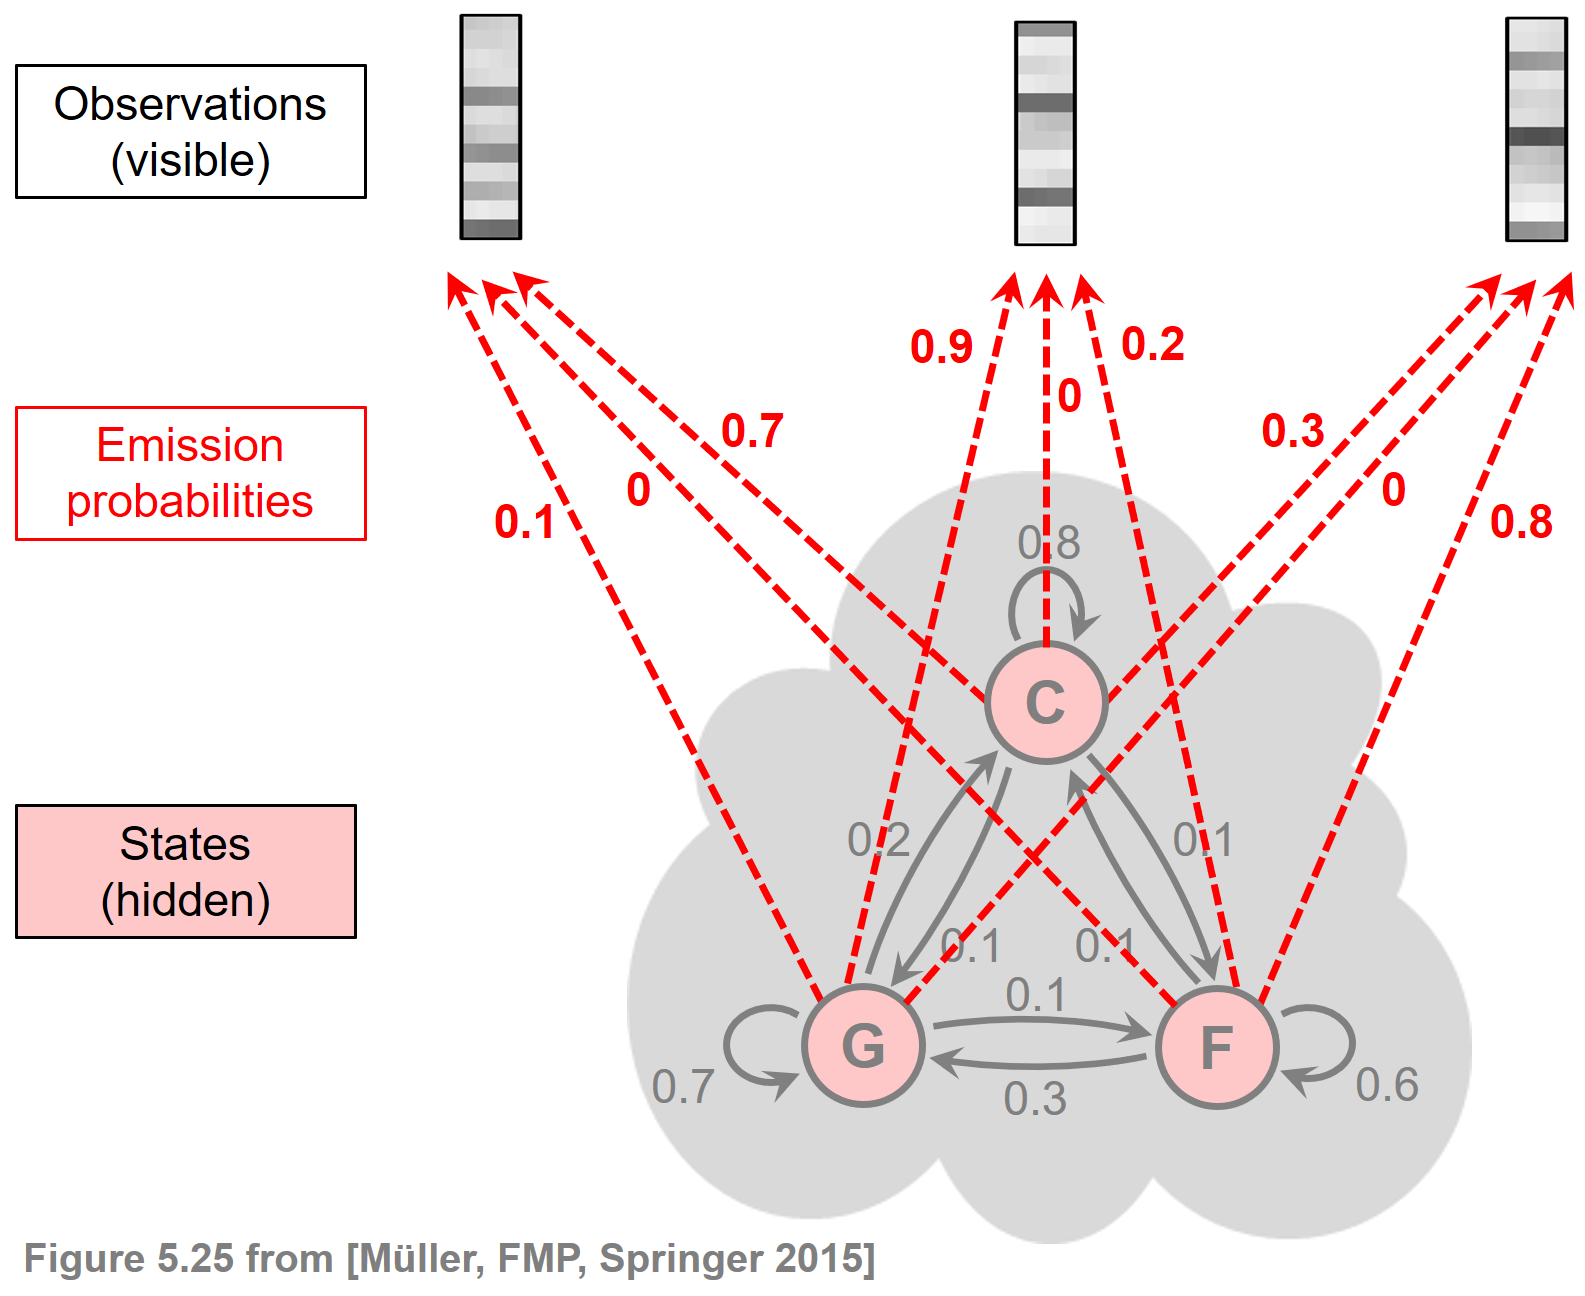

In [5]:
ipd.Image("../img/6.chord_recognition/FMP_C5_F25.png", width=500)

- 다음 코드 셀에서 그림에 지정된 대로 상태 전이 확률 행렬 $A$와 출력 확률 $B$를 정의한다.
    * 여기서는 $\alpha_{1}=\mathbf{C}$, $\alpha_{2}=\mathbf{G}$, $\alpha_{3}=\mathbf{F}$로 가정한다.
    * 또한 출력 공간 $\mathcal{B} = \{\beta_{1},\beta_{2},\beta_{3}\}$의 요소는 왼쪽에서 오른쪽으로 정렬된 세 개의 크로마 벡터를 나타낸다.
    * 마지막으로 초기 상태 확률 벡터 $C$가 $c_{1}=0.6$, $c_{2}=0.2$, $c_{3}=0.2$ 값으로 주어진다고 가정한다.

In [6]:
A = np.array([[0.8, 0.1, 0.1], 
              [0.2, 0.7, 0.1], 
              [0.1, 0.3, 0.6]])
C = np.array([0.6, 0.2, 0.2])
B = np.array([[0.7, 0.0, 0.3], 
              [0.1, 0.9, 0.0], 
              [0.0, 0.2, 0.8]])

## HMM 기반 시퀀스 생성

- HMM이 $\Theta:=(\mathcal{A},A,C,\mathcal{B},B)$로 지정되면, 다양한 분석 및 합성 응용에 사용할 수 있다.

- 이제 주어진 HMM을 기반으로 관측 시퀀스 $O=(o_{1},o_{2},\ldots,o_{N})$ (of length $N\in\mathbb{N}$ with $o_n\in \mathcal{B}$, $n\in[1:N]$)를 (인위적으로) 생성하는 방법에 대해 논의한다.

- 생성 절차는 다음과 같다.
    1. 초기 상태 분포 $C$에 따라 $n=1$로 설정하고 초기 상태 $s_n=\alpha_i$ (for some $i\in[1:I]$)를 선택한다.
    2. $s_n=\alpha_i$ state의 방출 확률에 따라 관찰 $o_n=\beta_k$ (for some $k\in[1:K]$)를 생성한다($B$의 $i^{\mathrm{th}}$ 행에 의해 지정됨)
    3. $n=N$이면 프로세스를 종료한다. 그렇지 않고 $n<N$인 경우, 상태 $s_n=\alpha_i$의 상태 전이 확률에 따라 새로운 상태 $s_{n+1}=\alpha_{j}$로 이동한다($A$의 $i^{\mathrm{th}}$ 행에 의해 지정됨). 그런 다음 $n$을 1씩 늘리고 2단계로 돌아간다.

- 다음 코드 셀에서는 이 절차를 구현하고 위에서 지정한 예제 HMM에 적용한다.

In [7]:
def generate_sequence_hmm(N, A, C, B, details=False):
    """Generate observation and state sequence from given HMM

    Args:
        N (int): Number of observations to be generated
        A (np.ndarray): State transition probability matrix of dimension I x I
        C (np.ndarray): Initial state distribution of dimension I
        B (np.ndarray): Output probability matrix of dimension I x K
        details (bool): If "True" then shows details (Default value = False)

    Returns:
        O (np.ndarray): Observation sequence of length N
        S (np.ndarray): State sequence of length N
    """
    assert N > 0, "N should be at least one"
    I = A.shape[1]
    K = B.shape[1]
    assert I == A.shape[0], "A should be an I-square matrix"
    assert I == C.shape[0], "Dimension of C should be I"
    assert I == B.shape[0], "Column-dimension of B should be I"

    O = np.zeros(N, int)
    S = np.zeros(N, int)
    for n in range(N):
        if n == 0:
            i = np.random.choice(np.arange(I), p=C)
        else:
            i = np.random.choice(np.arange(I), p=A[i, :])
        k = np.random.choice(np.arange(K), p=B[i, :])
        S[n] = i
        O[n] = k
        if details:
            print('n = %d, S[%d] = %d, O[%d] = %d' % (n, n, S[n], n, O[n]))
    return O, S

In [8]:
N = 10
O, S = generate_sequence_hmm(N, A, C, B, details=True)
print('State sequence S:      ', S)
print('Observation sequence O:', O)

n = 0, S[0] = 0, O[0] = 0
n = 1, S[1] = 0, O[1] = 2
n = 2, S[2] = 0, O[2] = 0
n = 3, S[3] = 0, O[3] = 0
n = 4, S[4] = 0, O[4] = 0
n = 5, S[5] = 0, O[5] = 0
n = 6, S[6] = 0, O[6] = 0
n = 7, S[7] = 0, O[7] = 0
n = 8, S[8] = 0, O[8] = 0
n = 9, S[9] = 0, O[9] = 2
State sequence S:       [0 0 0 0 0 0 0 0 0 0]
Observation sequence O: [0 2 0 0 0 0 0 0 0 2]


- 시퀀스 생성 접근 방식의 타당성에 대한 건전성 검사로서 이제 생성된 시퀀스가 HMM의 확률을 잘 반영하는지 확인한다. 이를 위해 생성된 관찰 시퀀스 $O$와 상태 시퀀스 $S$로부터 원래 전이 확률 행렬 $A$와 출력 확률 행렬 $B$를 추정한다.
    * $A$의 $a_{ij}$ 항목의 추정치를 얻기 위해 $S(n)=\alpha_i$ 및 $S(n+1)=\alpha_j$을 사용하여 $n$에서 $n+1$로의 모든 전환을 계산한다. 그런 다음 이 숫자를 $\alpha_i$로 시작해서 총 전환 수로 나눈다.
    * 마찬가지로, $B$의 $b_{ik}$ 항목에 대한 추정치를 얻기 위해 $S(n)=\alpha_i$ 및 $O(n)=\beta_k$에서 발생 횟수 $n$을 계산한다. 이 숫자를 $S$에서 $\alpha_i$의 총 발생 수로 나눈다.

- 숫자 $N$을 증가시켜 더 긴 시퀀스를 생성할 때, 결과 추정치는 $A$ 및 $B$의 원래 값에 근접해야 한다.

- 주의: 실제로 훈련 데이터에서 HMM 모델 매개변수를 추정할 때 일반적으로 **관측 시퀀스**만 사용할 수 있으며 상태 시퀀스(숨겨진 생성 프로세스를 반영)는 알려져 있지 않다. 관찰 시퀀스에서만 파라미터를 학습하면 아래에서 설명하는 것처럼 훨씬 더 어려운 추정 문제가 발생한다.

In [9]:
def estimate_hmm_from_o_s(O, S, I, K):
    """Estimate the state transition and output probability matrices from
    a given observation and state sequence

    Args:
        O (np.ndarray): Observation sequence of length N
        S (np.ndarray): State sequence of length N
        I (int): Number of states
        K (int): Number of observation symbols

    Returns:
        A_est (np.ndarray): State transition probability matrix of dimension I x I
        B_est (np.ndarray): Output probability matrix of dimension I x K
    """
    # Estimate A
    A_est = np.zeros([I, I])
    N = len(S)
    for n in range(N-1):
        i = S[n]
        j = S[n+1]
        A_est[i, j] += 1
    A_est = normalize(A_est, axis=1, norm='l1')

    # Estimate B
    B_est = np.zeros([I, K])
    for i in range(I):
        for k in range(K):
            B_est[i, k] = np.sum(np.logical_and(S == i, O == k))
    B_est = normalize(B_est, axis=1, norm='l1')
    return A_est, B_est

In [10]:
N = 100
print('======== Estimation results when using N = %d ========' % N)
O, S = generate_sequence_hmm(N, A, C, B, details=False)
A_est, B_est = estimate_hmm_from_o_s(O, S, A.shape[1], B.shape[1])
np.set_printoptions(formatter={'float': "{: 7.3f}".format})
print('A =', A, sep='\n')
print('A_est =', A_est, sep='\n')
print('B =', B, sep='\n')
print('B_est =', B_est, sep='\n')

N = 10000
print('======== Estimation results when using N = %d ========' % N)
O, S = generate_sequence_hmm(N, A, C, B, details=False)
A_est, B_est = estimate_hmm_from_o_s(O, S, A.shape[1], B.shape[1])
np.set_printoptions(formatter={'float': "{: 7.3f}".format})
print('A =', A, sep='\n')
print('A_est =', A_est, sep='\n')
print('B =', B, sep='\n')
print('B_est =', B_est, sep='\n')

======== Estimation results when using N = 100 ========
A =
[[  0.800   0.100   0.100]
 [  0.200   0.700   0.100]
 [  0.100   0.300   0.600]]
A_est =
[[  0.633   0.167   0.200]
 [  0.154   0.744   0.103]
 [  0.133   0.200   0.667]]
B =
[[  0.700   0.000   0.300]
 [  0.100   0.900   0.000]
 [  0.000   0.200   0.800]]
B_est =
[[  0.567   0.000   0.433]
 [  0.125   0.875   0.000]
 [  0.000   0.167   0.833]]
======== Estimation results when using N = 10000 ========
A =
[[  0.800   0.100   0.100]
 [  0.200   0.700   0.100]
 [  0.100   0.300   0.600]]
A_est =
[[  0.808   0.094   0.098]
 [  0.198   0.706   0.096]
 [  0.100   0.321   0.580]]
B =
[[  0.700   0.000   0.300]
 [  0.100   0.900   0.000]
 [  0.000   0.200   0.800]]
B_est =
[[  0.697   0.000   0.303]
 [  0.095   0.905   0.000]
 [  0.000   0.195   0.805]]


## HMM의 세 가지 문제

- 이제 매개변수의 지정 및 관찰 시퀀스의 평가와 관련된 HMM에 대한 세 가지 유명한 알고리즘 문제를 살펴본다.

### 평가 문제 (Evaluation Problem)

- 첫 번째 문제는 **평가 문제**이다. $\Theta=(\mathcal{A},A,C,\mathcal{B},B)$로 지정된 HMM과 관측 시퀀스 $O=(o_{1},o_{2},\ldots,o_{N})$가 주어지면, 주어진 모델의 관찰 시퀀스의 확률 $P[O|\Theta]$을 계산해야 한다.

- 조금 다른 관점에서 보면, 이 확률은 주어진 모델이 주어진 관측 시퀀스와 얼마나 잘 일치하는지를 나타내는 점수 값으로 볼 수 있다. 이러한 해석은 여러 경쟁 모델 중에서 하나를 선택하려는 경우에 유용하다. 따라서 해결책은 관측 시퀀스와 가장 일치하는 모델을 선택하는 것이다. 

- $P[O|\Theta]$를 계산하기 위해 먼저 길이가 $N$이고 적절한 $i_n\in[1:I]$, $n\in[1:N]$에 대한 $s_n=\alpha_{i_n}\in\mathcal{A}$인 고정 상태 시퀀스 $S=(s_1,s_2,\ldots,s_N)$를 고려한다. 

- 상태 시퀀스 $S$와 관찰 시퀀스 $O$를 생성할 확률 $P[O,S|\Theta]$는 다음과 같이 주어진다.
$$P[O,S|\Theta] = c_{i_1}\cdot b_{i_1k_1} \cdot a_{i_1i_2}\cdot b_{i_2k_2} \cdot ...\cdot a_{i_{N-1} i_N}\cdot b_{i_Nk_N}$$

- 다음으로 전체 확률 $P[O|\Theta]$를 얻으려면 $|S|=N$ 길이의 모든 가능한 상태 시퀀스 $S$를 고려하여 이러한 모든 확률을 합산해야 한다.
$$P[O|\Theta] = \sum_{S: |S|=N}P[O,S|\Theta]
= \sum_{i_1=1}^I \sum_{i_2=1}^I \ldots \sum_{i_N=1}^I
c_{i_1}\cdot b_{i_1k_1} \cdot a_{i_1i_2}\cdot b_{i_2k_2} \cdot ...\cdot a_{i_{N-1}i_N}\cdot b_{i_Nk_N}$$

- 이는 관찰 시퀀스의 길이 $N$에서 기하급수적인 숫자인 $I^N$ summands로 이어진다. 따라서 실제로 이 잔인한 계산 절차는 작은 $N$에 대해서도 계산적으로 불가능하다. 단, 동적 프로그래밍 패러다임을 기반으로 하는 알고리즘을 사용하여 $P[O|\Theta]$를 계산하는 보다 효율적인 방법이 있다. [Forward-Backward Algorithm](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm)이라고 하는 이 절차에는 $I^2N$ ($I^N$ 대신) 정도의 많은 작업이 필요하다.

### Uncovering 문제

- 두번째 문제는 **"uncovering" 문제**이다.
- 다시 $\Theta=(\mathcal{A},A,C,\mathcal{B},B)$로 주어진 HMM과 관찰 시퀀스 $O=(o_{1},o_{2 },\ldots,o_{N})$가 있을 때, **모든** 가능한 상태 시퀀스를 고려해야 하는 전체 확률 $P[O|\Theta]$ for $O$를 찾는 대신, uncovering 문제의 목표는 관찰 시퀀스를 "가장 잘 설명"하는 **단일** 상태 시퀀스 $S=(s_{1},s_{2},\ldots,s_{N})$을 찾는 것이다.

- 지금까지 언급된 uncovering 문제는 일반적으로 관찰 시퀀스를 생성하는 단일의 "올바른" 상태 시퀀스가 없기 때문에 잘 정의되지 않았다. 실제로 최상의 설명력에 대해 의미하는 바를 구체화하는 일종의 최적화 기준이 필요하다. 그러한 기준에 대한 몇 가지 합리적인 선택이 있으며, 의도된 응용에 따라 달라진다. 그 중 하나인 효율적인 알고리즘인 **Viterbi algorithm**에 대해 밑에서 논의하기로 한다. 이 알고리즘은 일종의 context-sensitive smoothing 절차로 생각할 수 있다.

### 추정 (Estimation) 문제

- HMM의 세번째 문제는 **추정 문제**이다. 
- 관찰 시퀀스 $O$가 주어지면 목표는 확률 $P[O|\Theta ]$을 최대화하는 $\Theta$의 ($A$, $C$, $B$로 지정된) 모델의 자유 매개변수를 결정하는 것이다. 다시말해, 관찰 시퀀스를 가장 잘 설명하는 매개변수를 추정하는 것이다. 
- 이것은 일련의 관찰 시퀀스가 HMM 매개변수를 조정하거나 학습하기 위한 **훈련 자료(training material)** 역할을 하는 **최적화 문제**의 전형적인 예이다. 추정 문제는 단연 HMM의 가장 어려운 문제이다. 사실 주어진 최적화 문제를 명시적으로 풀 수 있는 알려진 방법은 없다. 다만, 지역적으로 최적해를 찾는 반복적인 절차가 제시되어 왔다. 이러한 절차 중 하나는 **Baum-Welch 알고리즘**으로 알려져 있다.

# Viterbi 알고리즘

Lawrence R. Rabiner: <strong>A Tutorial on Hidden Markov Models and Selected Applications in Speech Recognition.</strong> Proceedings of the IEEE, 77 (1989), pp. 257&ndash;286. 

## Uncovering 문제와 Viterbi 알고리즘

- 위에서 화음 인식에서 발생하는 uncovering 문제에 대해 다루었다. 목표는 주어진 관측 시퀀스 $O=(o_{1},o_{2},\ldots,o_{N})$를 "가장 잘 설명하는" **단일(single)** 상태(state) 시퀀스 $S=(s_{1},s_{2},\ldots,s_{N})$를 찾는 것이다. 화음 인식 시나리오에서 관측 시퀀스는 오디오 녹음으로부터 추출한 크로마 벡터의 시퀀스이다. 최적 상태 시퀀스는 화음 라벨의 시퀀스이며 화음 인식 절차의 결과이다. 최적화 기준 중 하나로 관측 시퀀스 $0$에 반하여 평가될 때 가장 높은 확률 $\mathrm{Prob}^\ast$을 가지는 상태 시퀀스  $S^\ast$를 정하는 것이 있다.
$$\mathrm{Prob}^\ast
  = \underset{S=(s_{1},s_{2},\ldots,s_{N})}{\max} \,\,P[O,S|\Theta],\\
  S^\ast 
  = \underset{S=(s_{1},s_{2},\ldots,s_{N})}{\mathrm{argmax}} \,\,\,P[O,S|\Theta]$$

- naive한 접근 방식을 사용하여 시퀀스 $S^\ast$를 찾으려면, 길이 $N$의 $I^N$개의 가능한 상태 시퀀스 각각에 대한 확률 값 $P[O,S|\Theta]$를 계산해야 하고 최대화 인수를 찾아야 한다.


- 다행히도 훨씬 더 효율적인 방법으로 최적화 상태 시퀀스를 찾는 **Viterbi 알고리즘**이라는 기술이 있다. DTW 알고리즘과 유사한 Viterbi 알고리즘은 **동적 프로그래밍(dynamic progarmming)** 을 기반으로 한다.
- 하위 문제에 대한 최적 솔루션에서 최적(즉, 확률 최대화) 상태 시퀀스를 재귀적으로 계산한다. 여기에서 관측 시퀀스의 잘린 버전을 고려한다.

- $O=(o_{1},o_{2},\ldots o_{N})$를 관측 시퀀스라고 하자. 그러면 다음과 같이 정의할 수 있다.
$$O(1\!:\!n):=(o_{1},\ldots,o_{n})$$ 
of length $n\in[1:N]$.
$$ \mathbf{D}(i,n):=\underset{(s_1,\ldots,s_n)}{\max} P[O(1:n),(s_1,\ldots, s_{n-1},s_n=\alpha_i)|\Theta]$$ 
for $i\in[1:I]$. 

- 즉, $\mathbf{D}(i,n)$는 첫 번째 $n$개 관측을 설명하고 $s_{n}=\alpha_{i}$ 상태에서 끝나는 단일 상태 시퀀스 $(s_{1},\ldots,s_{n})$에서 가장 높은 확률이다.

- 다음의 최대값을 산출하는 상태 시퀀스는 uncovering 문제의 해답이다.
$$\mathbf{Prob}^\ast = \underset{i\in[1:I]}{\max}\,\,\mathbf{D}(i,N)$$

- $(I\times N)$ 행렬 $\mathbf{D}$는 열 인덱스 $n\in[1:N]$를 따라 재귀적으로 계산될 수 있다.

- Viterbi 알고리즘은 다음과 같다.

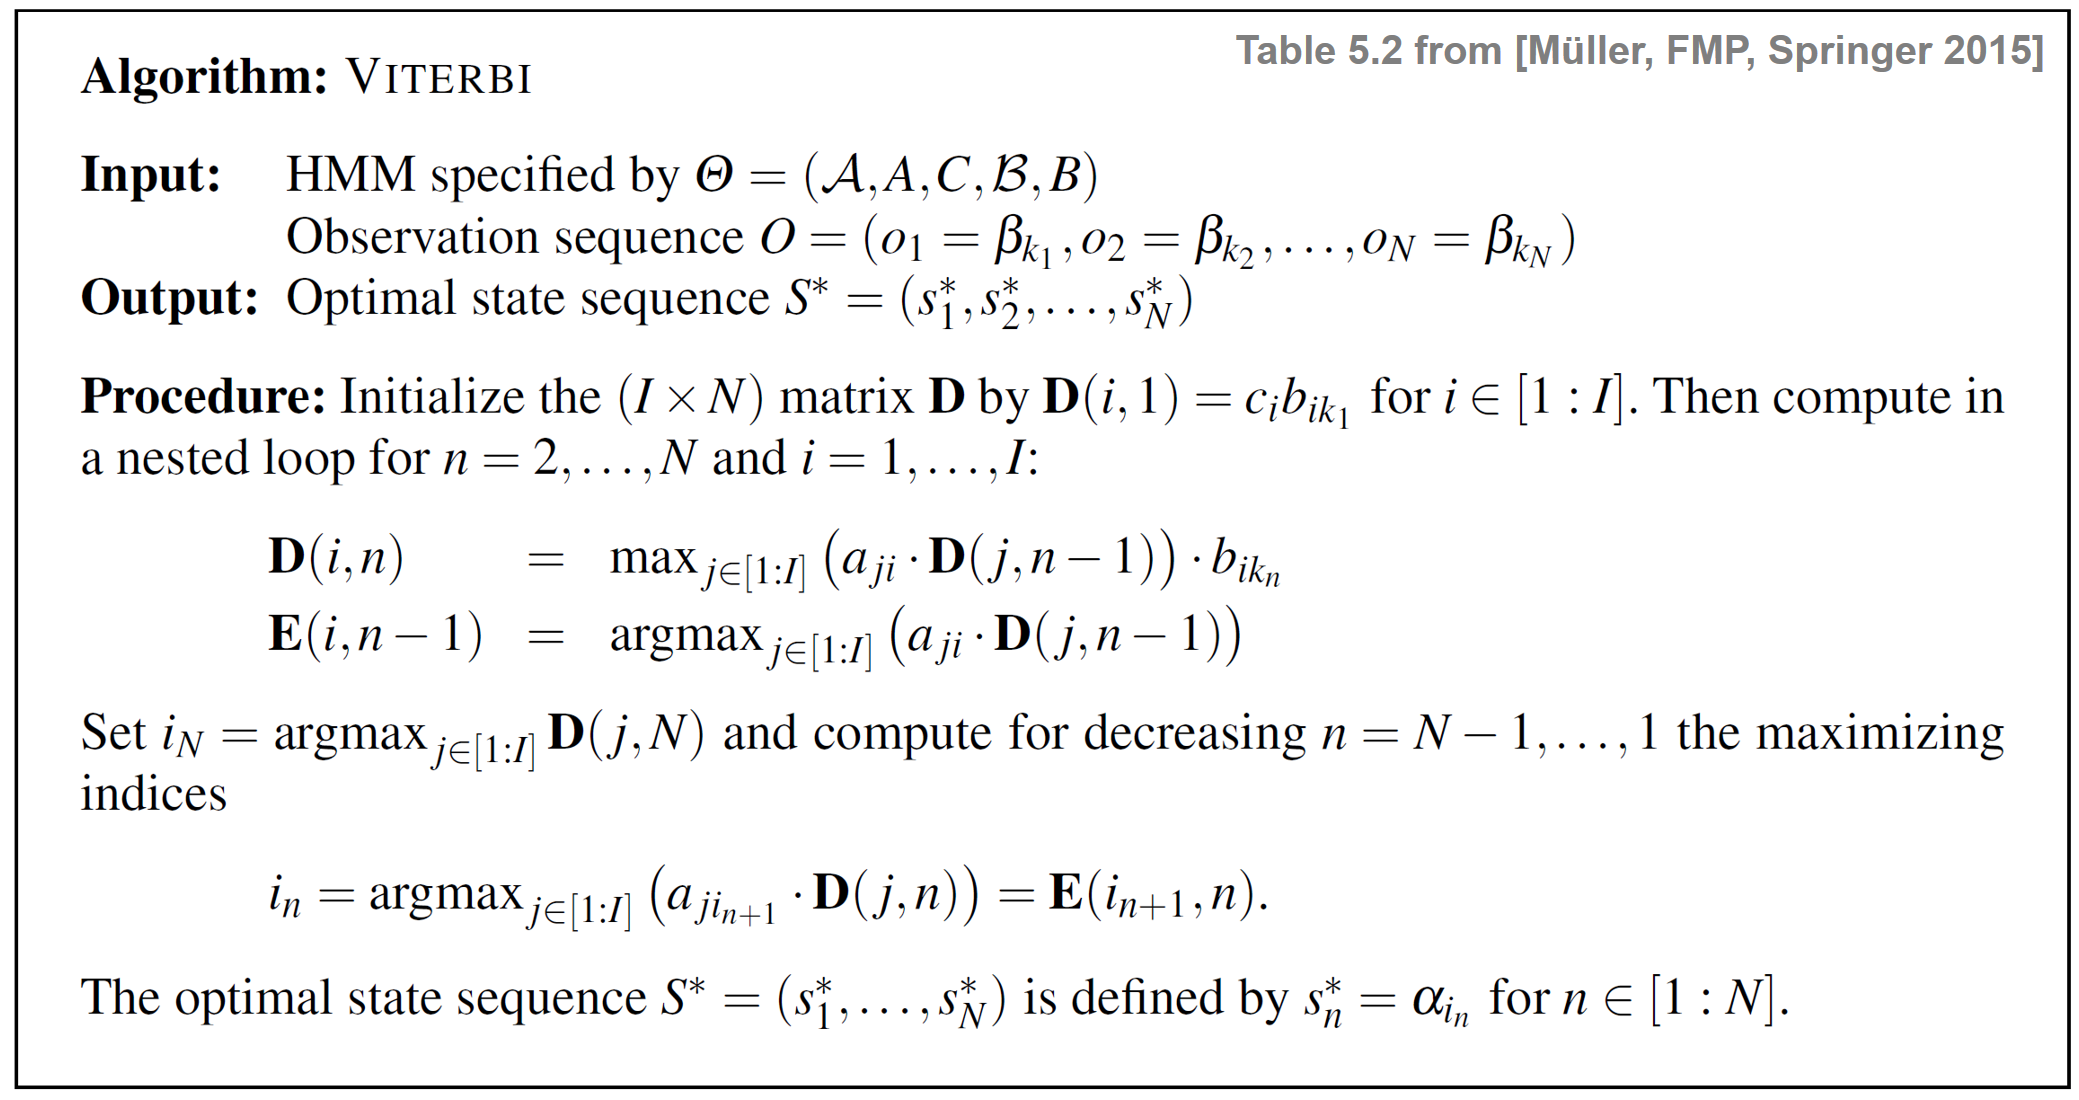

In [7]:
ipd.Image("../img/6.chord_recognition/FMP_C5_T02.png", width=600)

- 다음 그림은 Viterbi 알고리즘의 주요 단계를 보여준다.
     * 파란색 셀은 알고리즘의 **초기화** 역할을 하는 $\mathbf{D}(i,1)$ 항목을 나타낸다.
     * 빨간색 셀은 **주 반복(main iteration)** 의 계산을 나타낸다.
     * 검은색 셀은 최적의 상태 시퀀스를 얻기 위해 역 추적에 사용되는 **최대화 인덱스**를 나타낸다.
     * 행렬 $E$는 재귀에서 최대화 인덱스를 추적하는 데 사용된다. 이 정보는 두 번째 단계에서 **백트래킹(backtracking)** 을 사용하여 최적의 상태 시퀀스를 구성할 때 필요하다.

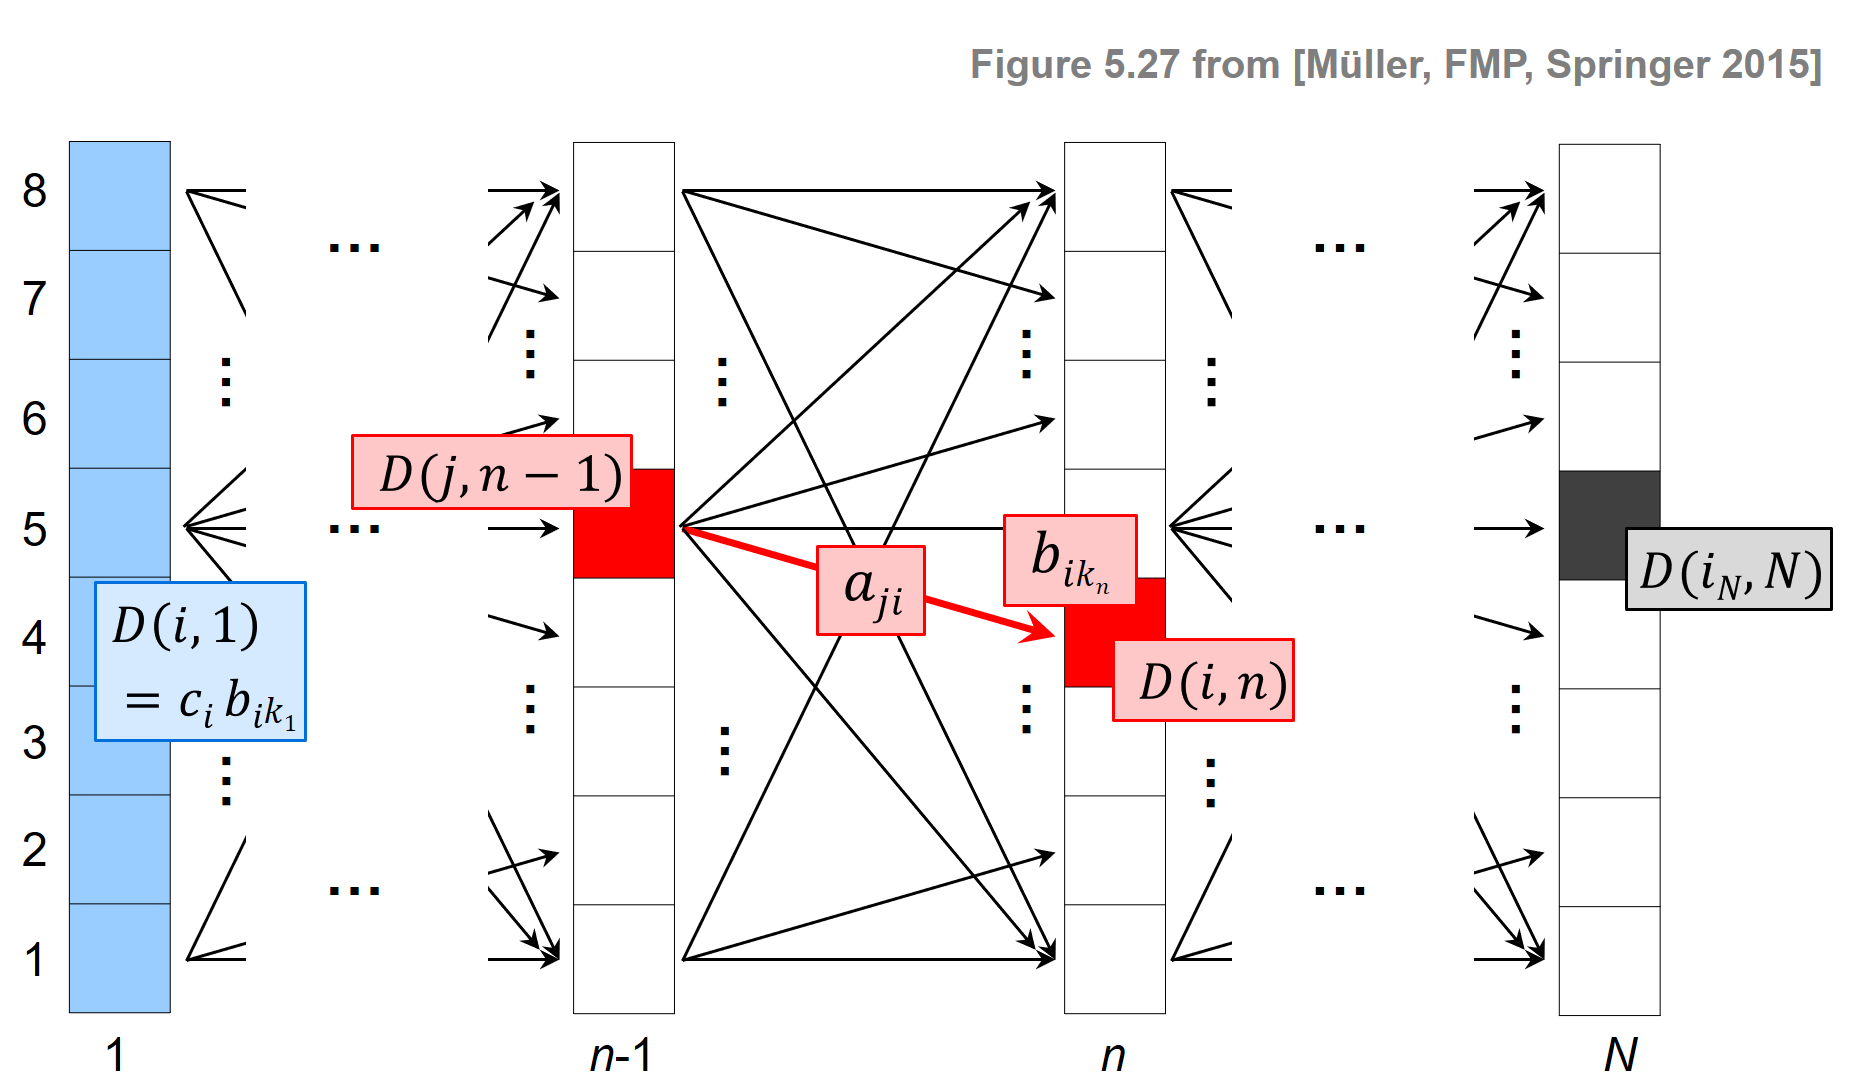

In [8]:
ipd.Image("../img/6.chord_recognition/FMP_C5_F27.png", width=600)

- 전체 절차는 DTW 알고리즘과 유사하며, 먼저 누적 비용 매트릭스를 구성한 다음 백트래킹을 사용하여 최적의 워핑 경로를 얻는다.
- 앞의 그림과 같이 Viterbi 알고리즘은 각각 $I$개 노드(상태)로 구성된 $N$개 레이어로 그래프와 같은 구조를 구축하는 반복적인 방식으로 진행된다.
- 또한 두 개의 이웃 레이어는 $I^2$ 에지로 연결되며, 이는 주어진 레이어에서 새 레이어를 구성하는 데 필요한 작업 수의 순서도 결정한다.
- 이로부터 Viterbi 알고리즘의 계산 복잡도는 $O(N\cdot I^2)$로, 나이브한 접근에 필요한 $O(I^N)$보다 훨씬 낫다.

- 예시

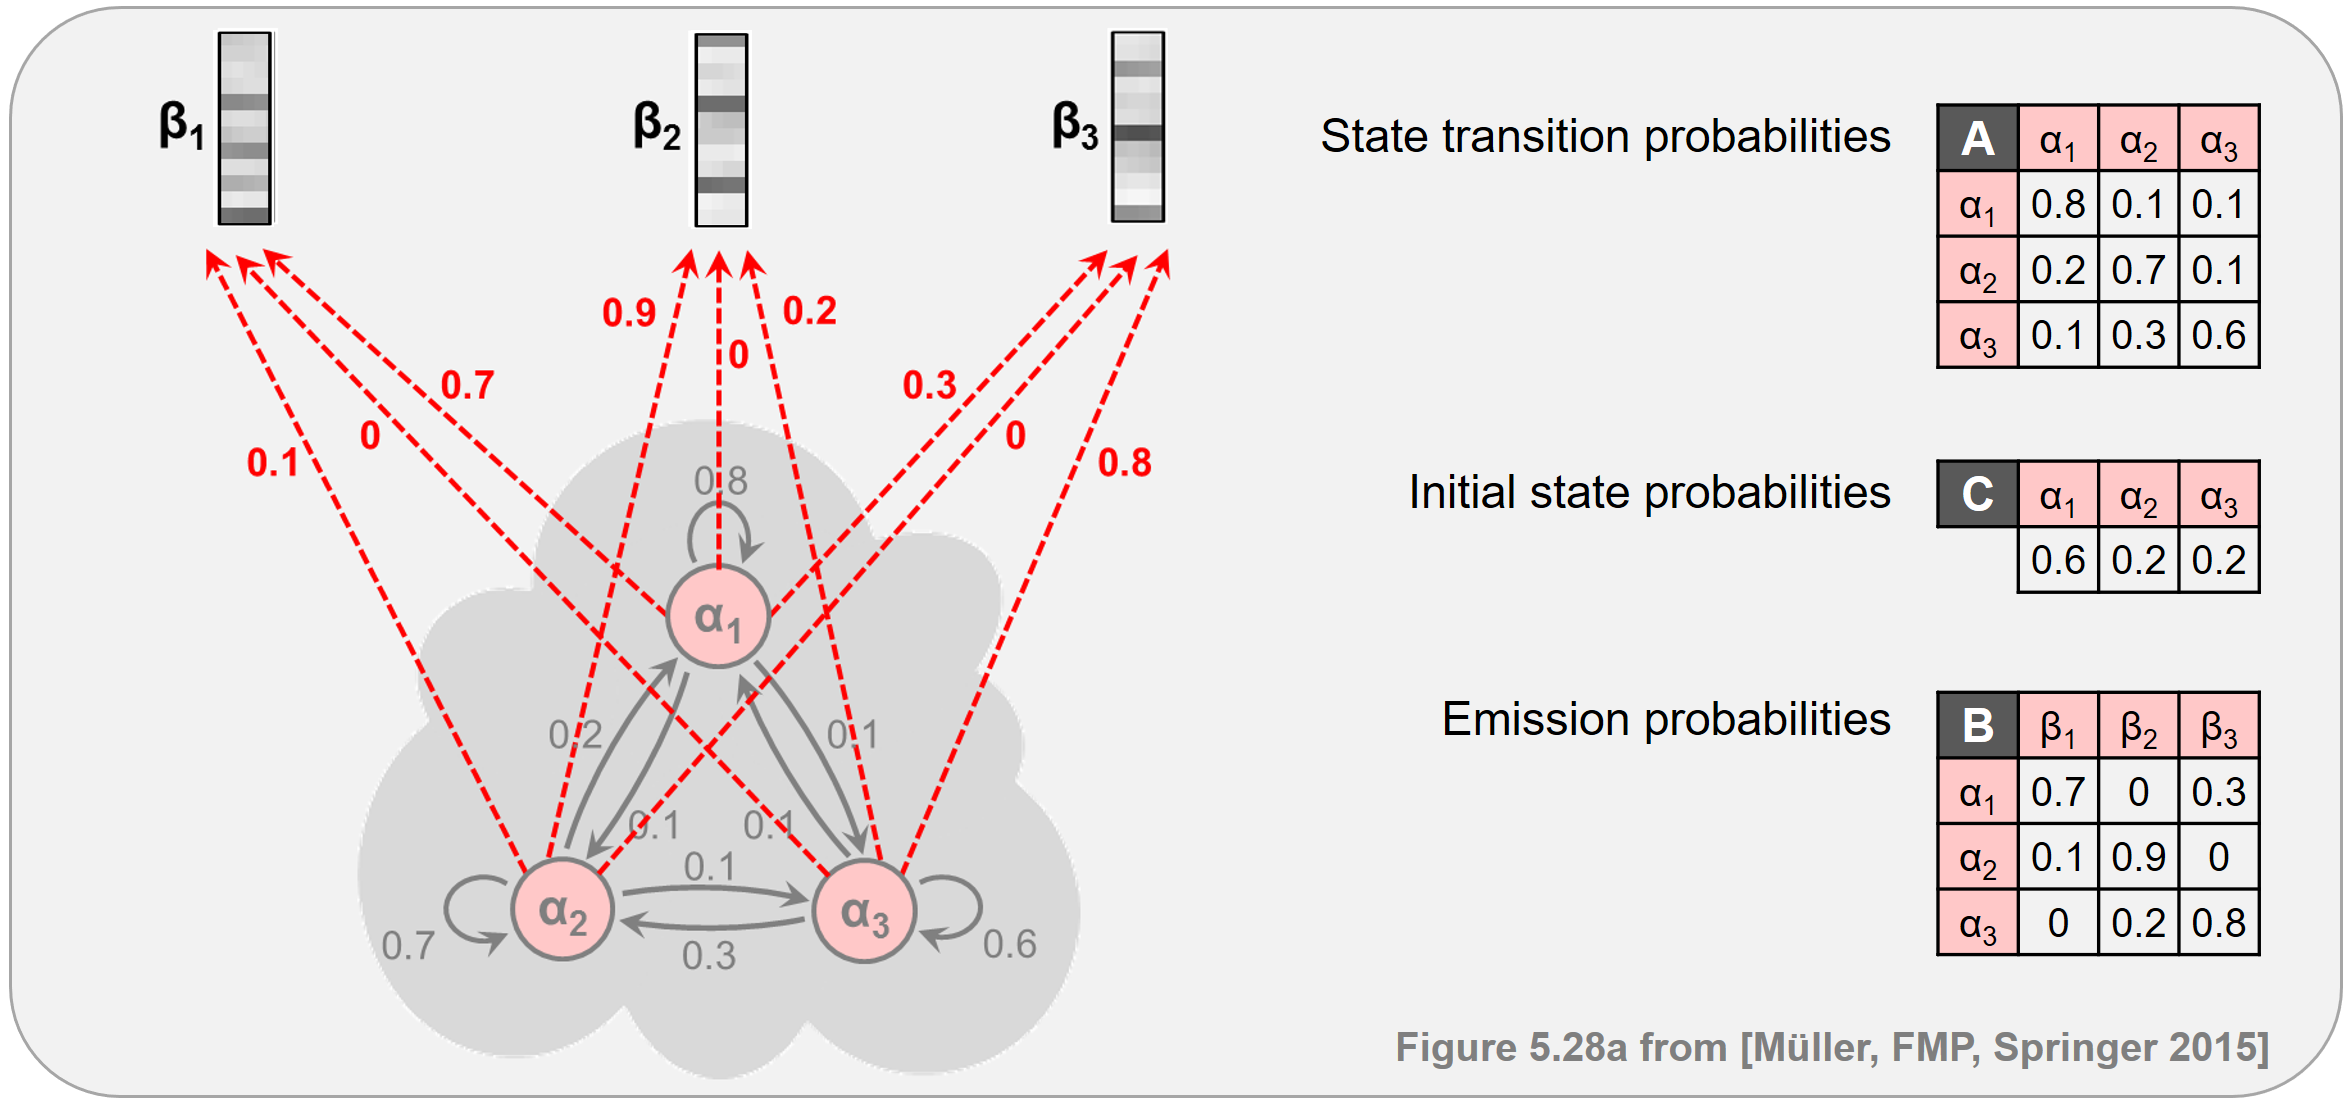

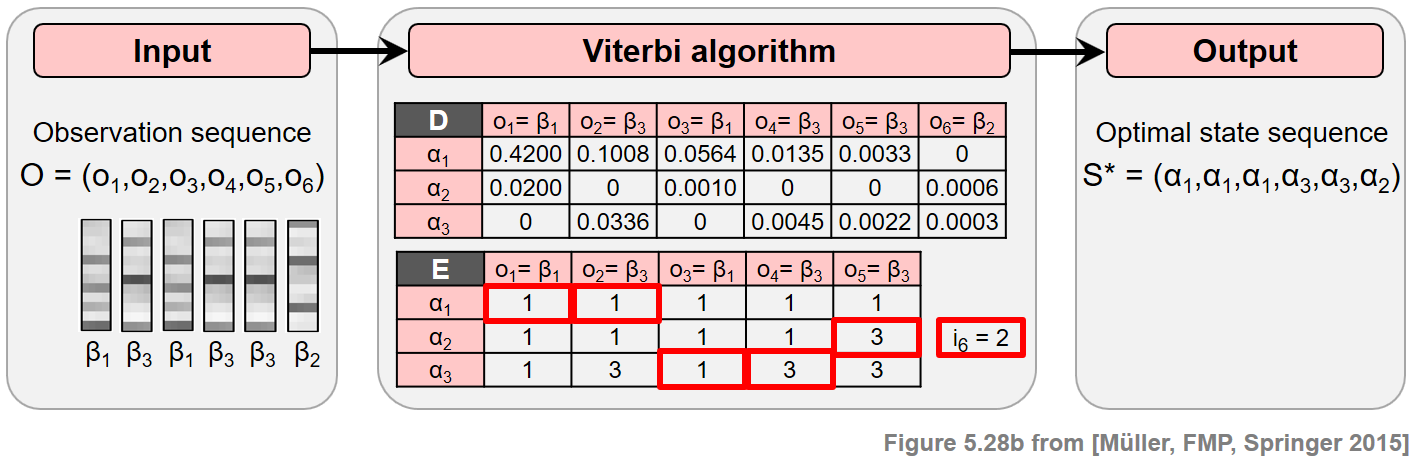

In [13]:
ipd.display(ipd.Image("../img/6.chord_recognition/FMP_C5_F28a.png", width=700))
ipd.display(ipd.Image("../img/6.chord_recognition/FMP_C5_F28b.png", width=700))

## Viterbi 알고리즘 실행

In [14]:
def viterbi(A, C, B, O):
    """Viterbi algorithm for solving the uncovering problem

    Args:
        A (np.ndarray): State transition probability matrix of dimension I x I
        C (np.ndarray): Initial state distribution  of dimension I
        B (np.ndarray): Output probability matrix of dimension I x K
        O (np.ndarray): Observation sequence of length N

    Returns:
        S_opt (np.ndarray): Optimal state sequence of length N
        D (np.ndarray): Accumulated probability matrix
        E (np.ndarray): Backtracking matrix
    """
    I = A.shape[0]    # Number of states
    N = len(O)  # Length of observation sequence

    # Initialize D and E matrices
    D = np.zeros((I, N))
    E = np.zeros((I, N-1)).astype(np.int32)
    D[:, 0] = np.multiply(C, B[:, O[0]])

    # Compute D and E in a nested loop
    for n in range(1, N):
        for i in range(I):
            temp_product = np.multiply(A[:, i], D[:, n-1])
            D[i, n] = np.max(temp_product) * B[i, O[n]]
            E[i, n-1] = np.argmax(temp_product)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D[:, -1])
    for n in range(N-2, -1, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]

    return S_opt, D, E

In [15]:
# Define model parameters
A = np.array([[0.8, 0.1, 0.1], 
              [0.2, 0.7, 0.1], 
              [0.1, 0.3, 0.6]])

C = np.array([0.6, 0.2, 0.2])

B = np.array([[0.7, 0.0, 0.3], 
              [0.1, 0.9, 0.0], 
              [0.0, 0.2, 0.8]])


O = np.array([0, 2, 0, 2, 2, 1]).astype(np.int32)
#O = np.array([1]).astype(np.int32)
#O = np.array([1, 2, 0, 2, 2, 1]).astype(np.int32)

# Apply Viterbi algorithm
S_opt, D, E = viterbi(A, C, B, O)
#
print('Observation sequence:   O = ', O)
print('Optimal state sequence: S = ', S_opt)
np.set_printoptions(formatter={'float': "{: 7.4f}".format})
print('D =', D, sep='\n')
np.set_printoptions(formatter={'float': "{: 7.0f}".format})
print('E =', E, sep='\n')

Observation sequence:   O =  [0 2 0 2 2 1]
Optimal state sequence: S =  [0 0 0 2 2 1]
D =
[[ 0.4200  0.1008  0.0564  0.0135  0.0033  0.0000]
 [ 0.0200  0.0000  0.0010  0.0000  0.0000  0.0006]
 [ 0.0000  0.0336  0.0000  0.0045  0.0022  0.0003]]
E =
[[0 0 0 0 0]
 [0 0 0 0 2]
 [0 2 0 2 2]]


## Viterbi Algorithm의 log-domain 실행

- Viterbi 알고리즘의 각 반복에서 $n-1$ 단계에서 누적된 $\mathbf{D}$의 확률값에 $A$와 $B$의 두 확률값을 곱한다.
- 더 정확하게는 다음과 같다.

$$\mathbf{D}(i,n) = \max_{j\in[1:I]}\big(a_{ij} \cdot\mathbf{D}(j,n-1) \big) \cdot b_ {i_{k_n}}$$

- 모든 확률 값은 $[0,1]$ 구간에 있기 때문에 이러한 값의 곱은 반복 횟수 $n$에 따라 기하급수적으로 감소한다. 결과적으로 $N$이 큰 입력 시퀀스 $O=(o_{1},o_{2},\ldots o_{N})$의 경우 $\mathbf{D}$의 값은 매우 작아지며, 결국 수치적 언더플로(underflow)로 이어질 수 있다.

- 확률 값의 곱을 다룰 때 잘 알려진 트릭은 **log-domain**에서 작업하는 것이다. 이를 위해 모든 확률 값에 로그를 적용하고 **곱셈을 합산으로 대체**한다. 로그는 강한 단조 함수이기 때문에 순서 관계는 로그 도메인에서 보존되어 **최대화** 또는 **최소화**와 같은 작업을 전달할 수 있다.

- 다음 코드 셀에서는 Viterbi 알고리즘의 **로그 변형**을 제공한다. 이 변형은 누적 로그 확률 행렬 $\log(\mathbf{D})$ (`D_log`)(로그가 각 항목에 적용됨)뿐만 아니라 원래 알고리즘과 정확히 동일한 최적 상태 시퀀스 $S^\ast$ 및 동일한 백트래킹 행렬 $E$를 생성한다. 또한 온전성 검사로서 계산된 로그 행렬 `D_log`에 지수 함수를 적용하여 위의 원래 Viterbi 알고리즘에 의해 계산된 행렬 `D`를 산출해야 한다.

In [16]:
def viterbi_log(A, C, B, O):
    """Viterbi algorithm (log variant) for solving the uncovering problem

    Args:
        A (np.ndarray): State transition probability matrix of dimension I x I
        C (np.ndarray): Initial state distribution  of dimension I
        B (np.ndarray): Output probability matrix of dimension I x K
        O (np.ndarray): Observation sequence of length N

    Returns:
        S_opt (np.ndarray): Optimal state sequence of length N
        D_log (np.ndarray): Accumulated log probability matrix
        E (np.ndarray): Backtracking matrix
    """
    I = A.shape[0]    # Number of states
    N = len(O)  # Length of observation sequence
    tiny = np.finfo(0.).tiny
    A_log = np.log(A + tiny)
    C_log = np.log(C + tiny)
    B_log = np.log(B + tiny)

    # Initialize D and E matrices
    D_log = np.zeros((I, N))
    E = np.zeros((I, N-1)).astype(np.int32)
    D_log[:, 0] = C_log + B_log[:, O[0]]

    # Compute D and E in a nested loop
    for n in range(1, N):
        for i in range(I):
            temp_sum = A_log[:, i] + D_log[:, n-1]
            D_log[i, n] = np.max(temp_sum) + B_log[i, O[n]]
            E[i, n-1] = np.argmax(temp_sum)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D_log[:, -1])
    for n in range(N-2, -1, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]

    return S_opt, D_log, E

In [17]:
# Apply Viterbi algorithm (log variant)
S_opt, D_log, E = viterbi_log(A, C, B, O)

print('Observation sequence:   O = ', O)
print('Optimal state sequence: S = ', S_opt)
np.set_printoptions(formatter={'float': "{: 7.2f}".format})
print('D_log =', D_log, sep='\n')
np.set_printoptions(formatter={'float': "{: 7.4f}".format})
print('exp(D_log) =', np.exp(D_log), sep='\n')
np.set_printoptions(formatter={'float': "{: 7.0f}".format})
print('E =', E, sep='\n')

Observation sequence:   O =  [0 2 0 2 2 1]
Optimal state sequence: S =  [0 0 0 2 2 1]
D_log =
[[  -0.87   -2.29   -2.87   -4.30   -5.73 -714.35]
 [  -3.91 -711.57   -6.90 -713.57 -715.00   -7.44]
 [-710.01   -3.39 -712.30   -5.40   -6.13   -8.25]]
exp(D_log) =
[[ 0.4200  0.1008  0.0564  0.0135  0.0033  0.0000]
 [ 0.0200  0.0000  0.0010  0.0000  0.0000  0.0006]
 [ 0.0000  0.0336  0.0000  0.0045  0.0022  0.0003]]
E =
[[0 0 0 0 0]
 [0 0 0 0 2]
 [0 2 0 2 2]]


# HMM 기반 화음 인식(Chord Recognition)

- HMM이 어떻게 자동 화음 인식을 개선하는데 적용될 수 있는지 알아보자.

- 우선, 화음 인식 문제에 적합한 HMM 모델을 만들어야 한다. 보통 HMM은 매개변수 $\Theta:=(\mathcal{A},A,C,\mathcal{B},B)$에 의해 구체화 된다.

- 화음 인식의 맥락에서 다음의 상태 집합은 화음 인식에서 허용되는 여러 화음 유형을 모델링하는데 사용된다.
$$\mathcal{A}:=\{\alpha_{1},\alpha_{2},\ldots,\alpha_{I}\}$$

- 템플릿-기반 화음 인식에서 그랬듯이, 여기서도 12 장3화음과 12 단3화음만 고려한다. 
$$\mathcal{A} = \{\mathbf{C},\mathbf{C}^\sharp,\ldots,\mathbf{B},\mathbf{Cm},\mathbf{Cm^\sharp},\ldots,\mathbf{Bm}\}$$

- 이 경우 HMM은 $I=24$ 개 상태로 구성된다. 예를 들어 $\alpha_{1}$는 $\mathbf{C}$에 해당하고 $\alpha_{13}$는 $\mathbf{Cm}$에 해당한다.

- 또한 다음을 수행한다.
     * 먼저, 음악적으로 정보를 얻는 방식으로 다른 HMM 매개변수를 지정하여 HMM을 명시적으로 생성하는 방법을 설명한다. 이러한 매개변수는 Baum-Welch 알고리즘을 사용하여 훈련 데이터에서 자동으로 학습될 수 있지만, HMM 매개변수의 수동적인 지정은 교육적이며 명시적인 음악적 의미를 가진 HMM으로 이끌 수 있다.
     * 둘째, 이 HMM을 화음 인식에 적용한다. HMM의 입력(즉, 관찰 시퀀스)은 음악 녹음의 **크로마그램 표현**이다. **Viterbi 알고리즘**을 적용하여 크로마 시퀀스를 가장 잘 설명하는 최적의 상태 시퀀스(화음 레이블로 구성됨)를 도출한다. 화음 라벨의 시퀀스는 프레임별 화음 인식 결과를 산출한다.

- HMM 기반의 화음 인식 결과와 템플릿 기반 접근 방식의 결과를 비교한다. 특히 HMM 전환 모델이 일종의 **context-aware postfiltering**(맥락을 인식하는 사후필터링)의 역할을 하는 것을 볼 수 있다.

## 방출 우도의 구체화 (Specification of Emission Likelihoods)

- 화음 인식 시나리오에서 관측값(observations)은 주어진 오디오 녹음에서 이전에 추출된 크로마 벡터이다. 즉, 관측값은 연속적인 특징 공간 $\mathcal{F}=\mathbb{R}^{12}$의 요소인 $12$차원의 실수 벡터이다.

- 지금까지는 관측값이 유한 출력 공간 $\mathcal{B}$에서 나오는 이산 기호인 **이산(discrete) HMM**의 경우만 고려했다. 이산 HMM을 시나리오에 적용하기 위해 가능한 절차 중 하나는 소위 **코드북(codebook)** 이라고 하는 프로토타입 벡터의 유한 세트를 도입하는 것이다. 이러한 코드북은 연속적인 특징 공간 $\mathcal{F}=\mathbb{R}^{12}$의 이산화로 간주될 수 있으며, 여기서 각 코드북 벡터는 전체 범위의 특징 벡터를 나타낸다. 그런 다음 이 유한한 코드북 벡터 세트를 기반으로 방출 확률(emission probability)을 결정할 수 있다.

- 대안으로 다음 HMM 변형에서 이산 출력 공간 $\mathcal{B}$를 연속적인 특징 공간 $\mathcal{F}=\mathbb{R}^{12}$ 및 **우도 함수(likelihood functions)** 에 의한 방출 확률 행렬 $B$로 대체한다. 특히, 주어진 상태의 방출 확률은 state-dependent한 정규화된 템플릿과 정규화된 관측(크로마) 벡터의 내적으로 정의되는 정규화된 유사성(similarity) 값으로 대체된다.

- $s:\mathcal{F} \times \mathcal{F} \to [0,1]$를 정규화된 크로미 벡터의 내적에 의해 정의된 **유사도 측정(similarity measure)** 이라고 하자(단, 0으로 나누지 못하도록 임계값을 설정한 정규화 사용):
$$s(x, y) = \frac{\langle x,y\rangle}{\|x\|_2\cdot\|y\|_2}$$
for $x,y\in\mathcal{F}$

- $I=24$개의 장,단3화음 (상태 $\mathcal{A}$로 인코딩되고 $[1:I]$ 집합으로 인덱싱됨)을 기반으로 **이진 화음 템플릿(binary chord templates)** $\mathbf{t}_i\in \mathcal{F}$  for $i\in [1:I]$을 고려한다.
- 그런 다음 state-dependent likelihood function $b_i:\mathcal{F}\to [0,1]$를 다음과 같이 정의한다.
$$b_i(x) := \frac{s(x, \mathbf{t}_i)}{\sum_{j\in[1:I]}s(x, \mathbf{t}_j)}$$
for $x\in\mathcal{F}$ and $i\in [1:I]$
    
- 시나리오에서 관측 시퀀스 $O=(o_{1},o_{2},\ldots,o_{N})$는 크로마 벡터 $o_n\in\mathcal{F}$의 시퀀스이다.

- 관측-종속적인 $(I\times N)$-행렬 $B[O]$를 다음과 같이 정의한다.
$$B[O](i,n) = b_i(o_n)$$
for $i\in[1:I]$ and $n\in[1:N]$
    
- 행렬은 템플릿 기반 화음 인식에 대한 [설명]()에서 소개되었듯이, **시간-화음 표현**의 형태로 시각화된 column-wise $\ell^1$-정규화를 사용하는 **화음 유사성 행렬(chord similarity matrix)** 이다. Viterbi 알고리즘의 맥락에서 likelihood $B[O](i,n)$는 확률 값 $b_{ik_n}$를 대체하는 데 사용된다.

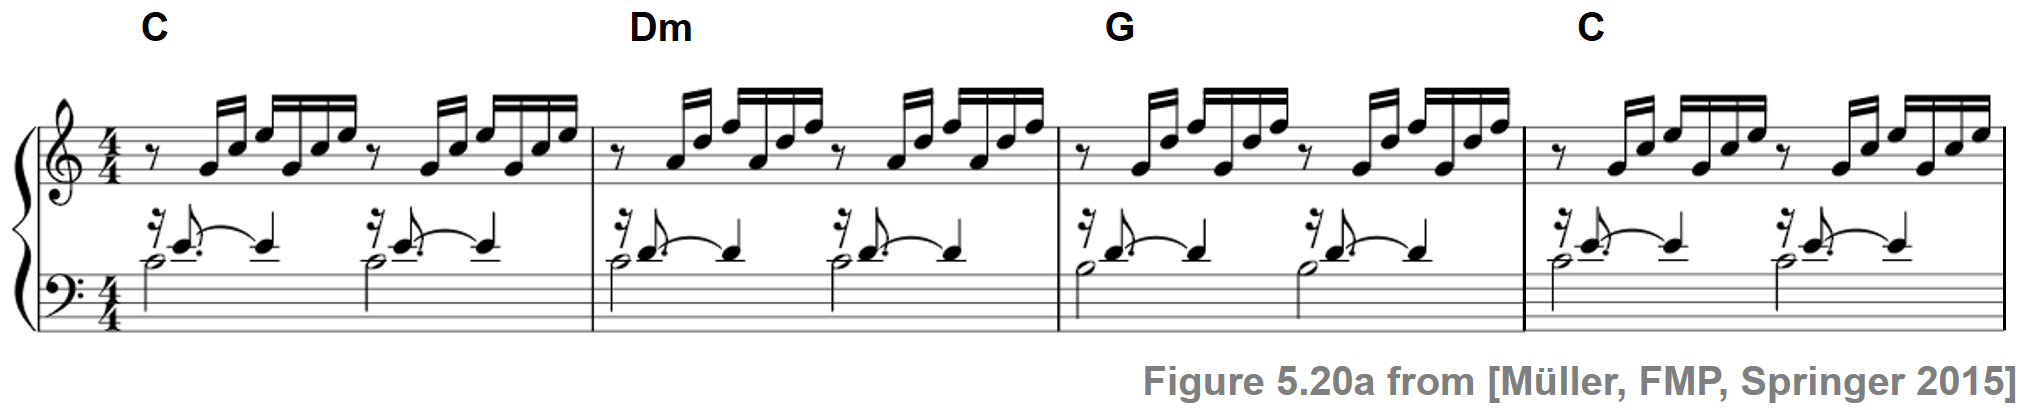

In [9]:
ipd.display(ipd.Image("../img/6.chord_recognition/FMP_C5_F20a.png", width=500))
ipd.display(ipd.Audio("../data_FMP/FMP_C5_F20_Bach_BWV846-mm1-4_Fischer.wav"))

In [26]:
# Specify 
fn_wav = "../data_FMP/FMP_C5_F20_Bach_BWV846-mm1-4_Fischer.wav"
fn_ann = "../data_FMP/FMP_C5_F20_Bach_BWV846-mm1-4_Fischer_ChordAnnotations.csv"
color_ann = {'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 'Dm': [1, 0, 0, 1], 'N': [1, 1, 1, 1]}

N = 4096
H = 1024
X, Fs_X, x, Fs, x_dur = \
    compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
N_X = X.shape[1]

# Chord recogntion
chord_sim, chord_max = chord_recognition_template(X, norm_sim='1')
chord_labels = get_chord_labels(nonchord=False)

# Annotations
chord_labels = get_chord_labels(ext_minor='m', nonchord=False)
ann_matrix, ann_frame, ann_seg_frame, ann_seg_ind, ann_seg_sec = convert_chord_ann_matrix(
    fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=True)
#P, R, F, TP, FP, FN = compute_eval_measures(ann_matrix, chord_max)

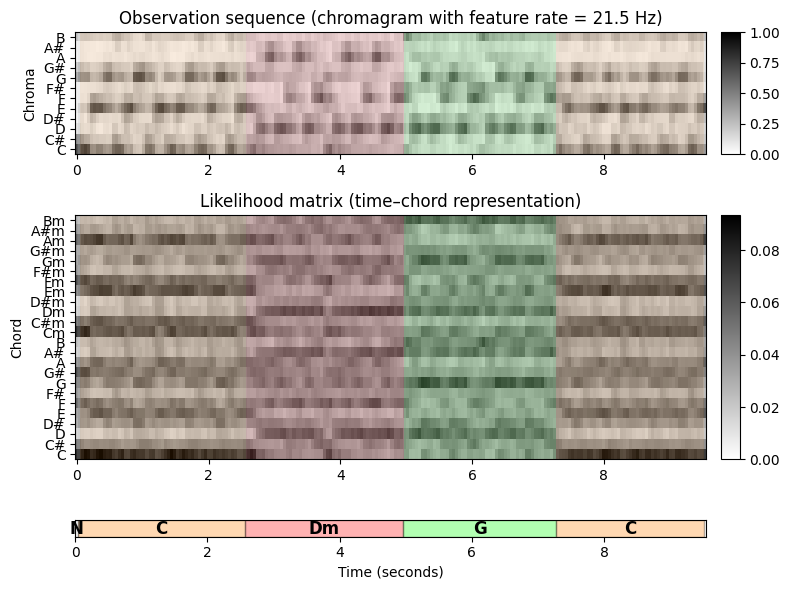

In [28]:
# Plot
cmap = compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1.5, 3, 0.2]}, figsize=(8, 6))

plot_chromagram(X, ax=[ax[0, 0], ax[0, 1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='Observation sequence (chromagram with feature rate = %0.1f Hz)' % (Fs_X))
plot_segments_overlay(ann_seg_sec, ax=ax[0, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

plot_matrix(chord_sim, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, clim=[0, np.max(chord_sim)],
                     title='Likelihood matrix (time–chord representation)',
                     ylabel='Chord', xlabel='')
ax[1, 0].set_yticks(np.arange(len(chord_labels)))
ax[1, 0].set_yticklabels(chord_labels)
plot_segments_overlay(ann_seg_sec, ax=ax[1, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

plot_segments(ann_seg_sec, ax=ax[2, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[2,1].axis('off')
plt.tight_layout()

## 전이 확률의 구체화 (Specification of Transition Probabilities)

- 음악에서 특정 화음 전환은 다른 화음 전환보다 더 자주 발생하기 마련이다. 따라서 HMM을 사용할 수 있으며, 다양한 화음 사이의 1차(first-oreder) 시간(temporal) 관계는 **전이 확률 행렬(transition probability matrix)** $A$로 캡처할 수 있다.

- 다음에서 $\alpha_{i}\rightarrow\alpha_{j}$ 표기법을 사용하여 $\alpha_{i}$ 상태에서 $\alpha_{j}$ 상태로 전환하는 것을 나타낸다. (for $i,j\in[1:I]$)

- 예를 들어, 계수 $a_{1,2}$는 전환 $\alpha_{1}\rightarrow\alpha_{2}$($\mathbf{C}\rightarrow\mathbf{C} ^\sharp$에 해당)의 확률을 표현하고, 반면 $a_{1,8}$는 $\alpha_{1}\rightarrow\alpha_{8}$($\mathbf{C}\rightarrow\mathbf{G}$에 해당)의 확률을 나타낸다.
- 실제 음악에서는 으뜸음(tonic)에서 딸림음(dominant)으로의 변화가 반음 하나 변화하는 것보다 훨씬 더 많으므로 $a_{1,8}$는 $a_{1,2}$보다 훨씬 커야 한다.
- 계수 $a_{i,i}$는 $\alpha_{i}$(for $i\in[1:I]$) (즉, $\alpha_{i}\rightarrow\alpha_{i}$) 상태에 머무를 확률을 나타낸다. 이러한 계수는 **자기 전이(self-transition)** 확률이라고도 한다.

- 전이 확률 행렬은 여러 가지 방법으로 구체화될 수 있다.
    - 예를 들어, 행렬은 화성 이론(harmony theory)의 규칙에 따라 음악 전문가가 수동으로 정의할 수 있다. 가장 일반적인 접근 방식은 레이블이 지정된 데이터에서 전환 확률을 추정하여 이러한 행렬을 자동으로 생성하는 것이다.
    
- 다음 그림에서는 세 가지 다른 전이 행렬을 보여준다(시각화 목적으로 로그 확률 척도를 사용).
     * 첫 번째는 비틀즈 컬렉션을 기반으로 레이블이 지정된 프레임 시퀀스에서 바이그램(bigram)(인접 요소 쌍)을 사용하여 레이블이 지정된 훈련 데이터에서 학습되었다. 예를 들어 계수 $a_{1,8}$(전환 $\mathbf{C}\rightarrow\mathbf{G}$에 해당)가 강조 표시되어있다.
     * 두 번째 행렬은 이전 행렬에서 얻은 **조옮김 불변(transposition-invariant)** 전이 확률 행렬이다. 조옮김 불변성을 달성하기 위해 레이블이 지정된 훈련 데이터 세트는 고려되는 바이그램에 대해 가능한 모든 12개의 순환 크로마 이동(cyclic chroma shifts)을 고려하여 보강된다.
     * 세 번째 행렬은 주 대각선(자기 전이)에서 큰 값을 갖고 나머지 모든 위치에서 훨씬 작은 값을 갖는 **균일(uniform)** 전이 확률 행렬이다.

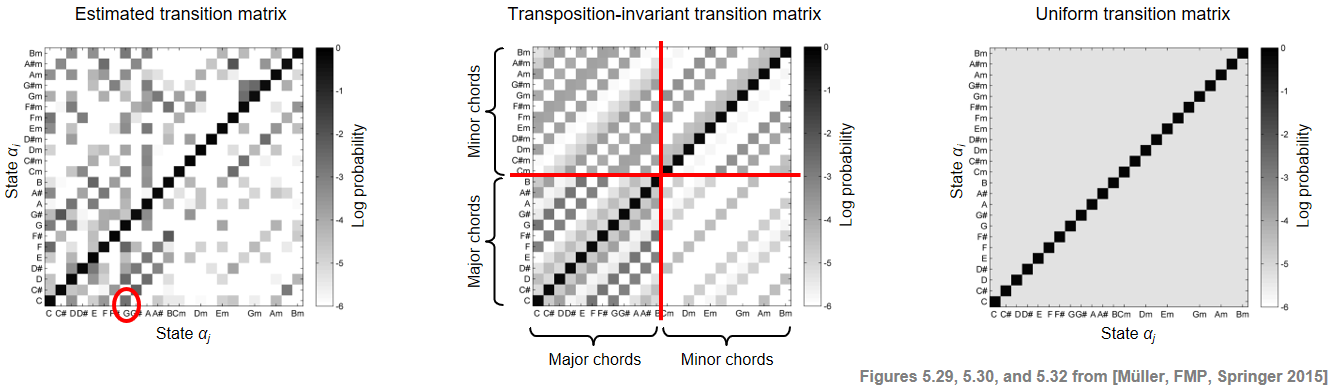

In [39]:
ipd.Image("../img/6.chord_recognition/FMP_C5_F29-30-32.png")

- 다음 코드 셀에서 비틀즈 컬렉션을 기반으로 추정된(6.4.에서 이를 다루기로 함) 미리 계산된 전환 행렬이 포함된 `CSV` 파일을 읽는다. 그림에서는 확률 값과 로그 확률 값을 모두 표시한다.

In [40]:
def plot_transition_matrix(A, log=True, ax=None, figsize=(6, 5), title='',
                           xlabel='State (chord label)', ylabel='State (chord label)',
                           cmap='gray_r', quadrant=False):
    """Plot a transition matrix for 24 chord models (12 major and 12 minor triads)

    Args:
        A: Transition matrix
        log: Show log probabilities (Default value = True)
        ax: Axis (Default value = None)
        figsize: Width, height in inches (only used when ax=None) (Default value = (6, 5))
        title: Title for plot (Default value = '')
        xlabel: Label for x-axis (Default value = 'State (chord label)')
        ylabel: Label for y-axis (Default value = 'State (chord label)')
        cmap: Color map (Default value = 'gray_r')
        quadrant: Plots additional lines for C-major and C-minor quadrants (Default value = False)

    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes.
        im: The image plot
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax = [ax]

    if log is True:
        A_plot = np.log(A)
        cbar_label = 'Log probability'
        clim = [-6, 0]
    else:
        A_plot = A
        cbar_label = 'Probability'
        clim = [0, 1]
    im = ax[0].imshow(A_plot, origin='lower', aspect='equal', cmap=cmap, interpolation='nearest')
    im.set_clim(clim)
    plt.sca(ax[0])
    cbar = plt.colorbar(im)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    cbar.ax.set_ylabel(cbar_label)

    chord_labels = get_chord_labels()
    chord_labels_squeezed = chord_labels.copy()
    for k in [1, 3, 6, 8, 10, 11, 13, 15, 17, 18, 20, 22]:
        chord_labels_squeezed[k] = ''

    ax[0].set_xticks(np.arange(24))
    ax[0].set_yticks(np.arange(24))
    ax[0].set_xticklabels(chord_labels_squeezed)
    ax[0].set_yticklabels(chord_labels)

    if quadrant is True:
        ax[0].axvline(x=11.5, ymin=0, ymax=24, linewidth=2, color='r')
        ax[0].axhline(y=11.5, xmin=0, xmax=24, linewidth=2, color='r')

    return fig, ax, im

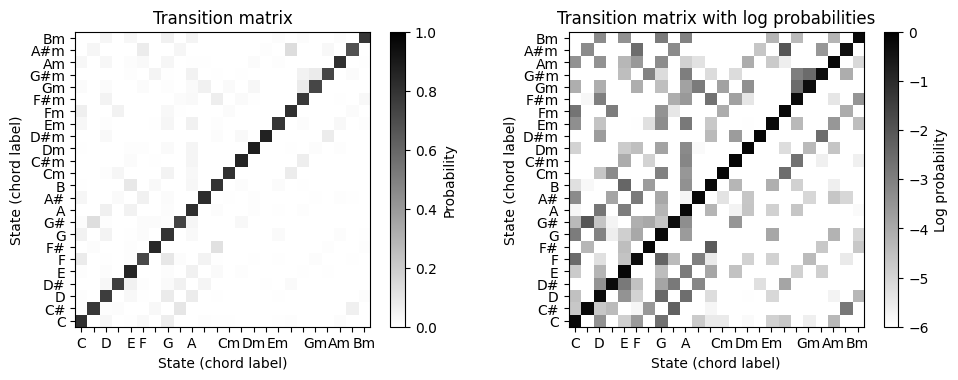

In [41]:
# Load transition matrix estimated on the basis of the Beatles collection
fn_csv = '../data_FMP/FMP_C5_transitionMatrix_Beatles.csv'
A_est_df = pd.read_csv(fn_csv, delimiter=';')
A_est = A_est_df.to_numpy('float64')

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 
                                          'height_ratios': [1]}, 
                       figsize=(10, 3.8))

plot_transition_matrix(A_est, log=False, ax=[ax[0]], title='Transition matrix')
plot_transition_matrix(A_est, ax=[ax[1]], title='Transition matrix with log probabilities')
plt.tight_layout()

- **조옮김-불변 전이 행렬** (**transposition-invariant transition matrix**)을 얻기 위해 원래 행렬의 4개 사분면(장화음, 단화음 영역으로 정의됨)을 순환 이동하고 평균화하여 행렬 수준에서 순환 크로마 이동을 시뮬레이션한다. 
- 그림에서 원본의 전이 행렬과 결과의 옮김-불변 전이 행렬을 보여준다.

In [42]:
def matrix_circular_mean(A):
    """Computes circulant matrix with mean diagonal sums

    Args:
        A (np.ndarray): Square matrix

    Returns:
        A_mean (np.ndarray): Circulant output matrix
    """
    N = A.shape[0]
    A_shear = np.zeros((N, N))
    for n in range(N):
        A_shear[:, n] = np.roll(A[:, n], -n)
    circ_sum = np.sum(A_shear, axis=1)
    A_mean = circulant(circ_sum) / N
    return A_mean
    
    
def matrix_chord24_trans_inv(A):
    """Computes transposition-invariant matrix for transition matrix
    based 12 major chords and 12 minor chords

    Args:
        A (np.ndarray): Input transition matrix

    Returns:
        A_ti (np.ndarray): Output transition matrix
    """
    A_ti = np.zeros(A.shape)
    A_ti[0:12, 0:12] = matrix_circular_mean(A[0:12, 0:12])
    A_ti[0:12, 12:24] = matrix_circular_mean(A[0:12, 12:24])
    A_ti[12:24, 0:12] = matrix_circular_mean(A[12:24, 0:12])
    A_ti[12:24, 12:24] = matrix_circular_mean(A[12:24, 12:24])
    return A_ti

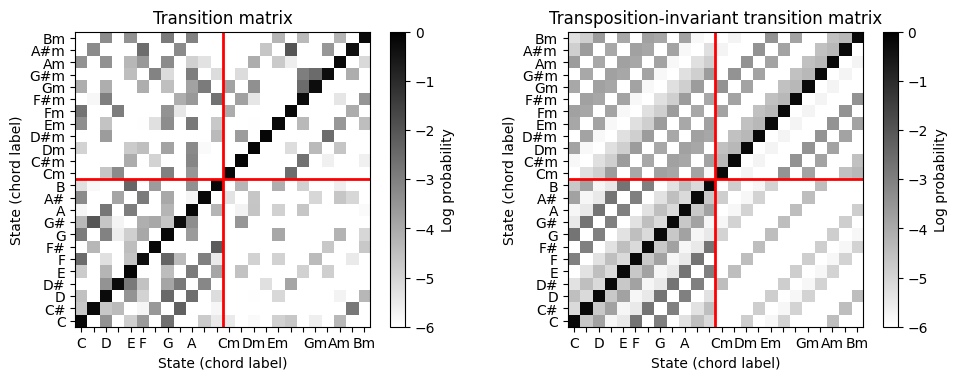

In [43]:
A_ti = matrix_chord24_trans_inv(A_est)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 
                                          'height_ratios': [1]}, 
                       figsize=(10, 3.8))

plot_transition_matrix(A_est, ax=[ax[0]], quadrant=True, 
                       title='Transition matrix')
plot_transition_matrix(A_ti, ax=[ax[1]], quadrant=True, 
                       title='Transposition-invariant transition matrix')
plt.tight_layout()

- 마지막으로 uniform 전이 확률 행렬을 생성하는 기능을 보자. 이 함수에는 자기 전이 확률(주대각선의 값)을 결정하는 매개변수 $p\in[0,1]$가 있다. 나머지 위치에 대한 확률은 결과 행렬이 확률 행렬(즉, 모든 행과 열의 합이 1이 됨)이 되도록 설정한다.

In [44]:
def uniform_transition_matrix(p=0.01, N=24):
    """Computes uniform transition matrix

    Args:
        p (float): Self transition probability (Default value = 0.01)
        N (int): Column and row dimension (Default value = 24)

    Returns:
        A (np.ndarray): Output transition matrix
    """
    off_diag_entries = (1-p) / (N-1)     # rows should sum up to 1
    A = off_diag_entries * np.ones([N, N])
    np.fill_diagonal(A, p)
    return A

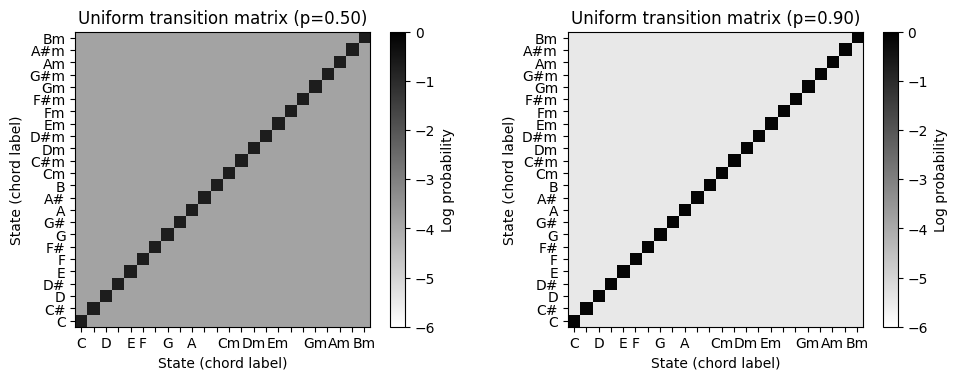

In [45]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 
                                          'height_ratios': [1]}, 
                       figsize=(10, 3.8))

p = 0.5
A_uni = uniform_transition_matrix(p)
plot_transition_matrix(A_uni, ax=[ax[0]], title='Uniform transition matrix (p=%0.2f)' % p)
p = 0.9
A_uni = uniform_transition_matrix(p)
plot_transition_matrix(A_uni, ax=[ax[1]], title='Uniform transition matrix (p=%0.2f)' % p)
plt.tight_layout()

## HMM 기반 화음 인식 (HMM-Based Chord Recognition)

- 앞에서 설명한 것처럼 HMM 기반 모델의 자유 매개변수는 훈련 세트에서 자동으로 학습하거나 음악적 지식을 사용하여 수동으로 설정할 수 있다.

- Bach 예제를 계속 사용하여 HMM을 화음 인식 시나리오에 적용한 효과를 본다. 다음 설정을 사용한다.
     * 관찰 시퀀스 $O$으로, 크로마 벡터 시퀀스를 사용한다.
     * 전이 확률 행렬 $A$는 균일(uniform) 전이 행렬을 사용한다.
     * 초기 상태 확률 벡터 $C$는 균일 분포를 사용한다.
     * 방출(emission) 확률 행렬 $B$는 템플릿 기반 화음 인식에도 사용되는 화음 유사성 행렬의 정규화된 버전인 liklihood 행렬 $B[O]$로 대체한다.
     * 프레임별 화음 인식 결과는 Viterbi 알고리즘에 의해 계산된 상태 시퀀스에 의해 제공된다.

- 방출 확률 대신 likelihood 행렬 $B[O]$를 사용하려면 원래 알고리즘을 약간 수정해야 한다. 다음 코드 셀에서는 수치적으로 안정적인 로그 버전을 사용하여 수정한다. 그런 다음 HMM 기반 결과와 템플릿 기반 접근 방식을 비교하여 평가 결과를 시간-화음 시각화 형태로 각각 보여준다.

In [54]:
def viterbi_log_likelihood(A, C, B_O):
    """Viterbi algorithm (log variant) for solving the uncovering problem

    Args:
        A (np.ndarray): State transition probability matrix of dimension I x I
        C (np.ndarray): Initial state distribution  of dimension I
        B_O (np.ndarray): Likelihood matrix of dimension I x N

    Returns:
        S_opt (np.ndarray): Optimal state sequence of length N
        S_mat (np.ndarray): Binary matrix representation of optimal state sequence
        D_log (np.ndarray): Accumulated log probability matrix
        E (np.ndarray): Backtracking matrix
    """
    I = A.shape[0]    # Number of states
    N = B_O.shape[1]  # Length of observation sequence
    tiny = np.finfo(0.).tiny
    A_log = np.log(A + tiny)
    C_log = np.log(C + tiny)
    B_O_log = np.log(B_O + tiny)

    # Initialize D and E matrices
    D_log = np.zeros((I, N))
    E = np.zeros((I, N-1)).astype(np.int32)
    D_log[:, 0] = C_log + B_O_log[:, 0]

    # Compute D and E in a nested loop
    for n in range(1, N):
        for i in range(I):
            temp_sum = A_log[:, i] + D_log[:, n-1]
            D_log[i, n] = np.max(temp_sum) + B_O_log[i, n]
            E[i, n-1] = np.argmax(temp_sum)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D_log[:, -1])
    for n in range(N-2, -1, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]

    # Matrix representation of result
    S_mat = np.zeros((I, N)).astype(np.int32)
    for n in range(N):
        S_mat[S_opt[n], n] = 1

    return S_mat, S_opt, D_log, E

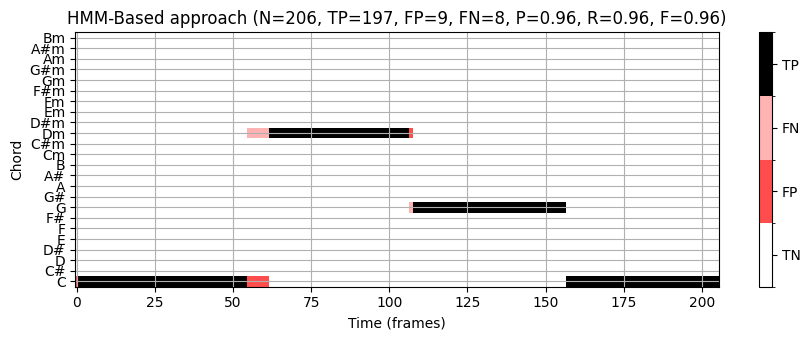

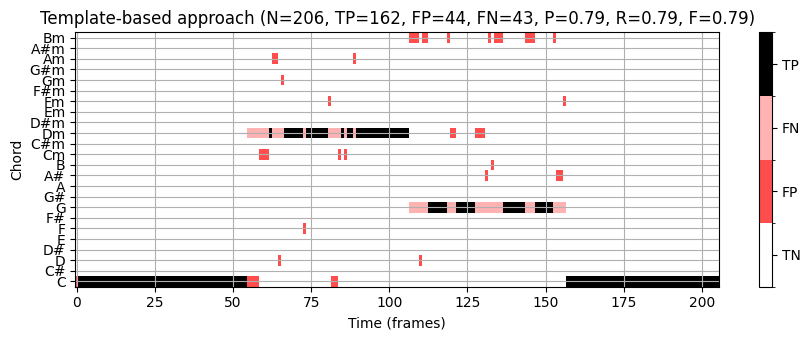

In [56]:
A = uniform_transition_matrix(p=0.5)
C = 1 / 24 * np.ones((1, 24))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

P, R, F, TP, FP, FN = compute_eval_measures(ann_matrix, chord_HMM)
title = 'HMM-Based approach (N=%d, TP=%d, FP=%d, FN=%d, P=%.2f, R=%.2f, F=%.2f)' % (N_X, TP, FP, FN, P, R, F)
fig, ax, im = plot_matrix_chord_eval(ann_matrix, chord_HMM, Fs=1, 
                     title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_labels)
plt.tight_layout()
plt.show()

P, R, F, TP, FP, FN = compute_eval_measures(ann_matrix, chord_max)
title = 'Template-based approach (N=%d, TP=%d, FP=%d, FN=%d, P=%.2f, R=%.2f, F=%.2f)' %\
    (N_X, TP, FP, FN, P, R, F)
fig, ax, im = plot_matrix_chord_eval(ann_matrix, chord_max, Fs=1, 
                     title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_labels)
plt.tight_layout()
plt.show()

- 이 예에서는 HMM 기반 화음 인식기가 템플릿 기반 접근 방식보다 우수하다.

- HMM 기반 접근 방식의 개선은 특히 상황에 맞는 평활화(smoothing)를 도입하는 **전이 모델(transition model)** 에서 비롯된다. **높은 자기-전이 확률**의 경우, 화음 인식기는 다른 화음으로 변경하기보다 현재 화음에 머무르는 경향이 있으며, 이는 일종의 평활화라고 볼 수 있다. 이 효과는 깨진(broken) 화음이 짧은 시간의 많은 화음 모호성을 유발하는 Bach 예제에서도 입증된다. 이러한 효과는 간단한 템플릿 기반 화음 인식기를 사용할 때 많은 무작위와 같은 화음 변경으로 이어지게 한다.

- HMM 기반 접근 방식을 사용하면 상대적으로 낮은 전이 확률이 방출 확률의 충분한 증가로 보상되는 경우에만 화음 변경이 수행된다. 결과적으로 지배적인 화음 변경만 남는다.

## 사전 필터링 vs. 사후 필터링 (Prefiltering vs. Postfiltering)

- [화음 인식 평가]()에서 다룬 입력 크로마그램을 계산할 때 더 긴 윈도우 크기를 적용하여 개선을 달성할 수 있음을 Bach 예제로 보여주었다.

- 더 긴 윈도우 크기를 적용하면 관측 시퀀스의 시간적 평활화 정도가 더 많거나 적다. 이 평활화는 패턴 매칭 단계 **이전에** 수행되므로, 이 전략을 **사전 필터링(prefiltering)** 이라고도 한다. 이러한 사전 필터링 단계는 노이즈와 같은 프레임을 부드럽게 처리할 뿐만 아니라 특징적인 크로마 정보를 제거하고 전환을 흐리게 한다.

- 사전 필터링과 달리 HMM 기반 접근 방식은 특징(feature) 표현을 그대로 둔다. 또한, 평활화는 패턴 매칭 단계와 조합하여 수행된다. 이러한 이유로 이 접근 방식을 **사후 필터링(postfiltering)** 이라고도 한다. 결과적으로 원래 크로마 정보가 보존되고 특징 표현의 전환이 선명하게 유지된다.

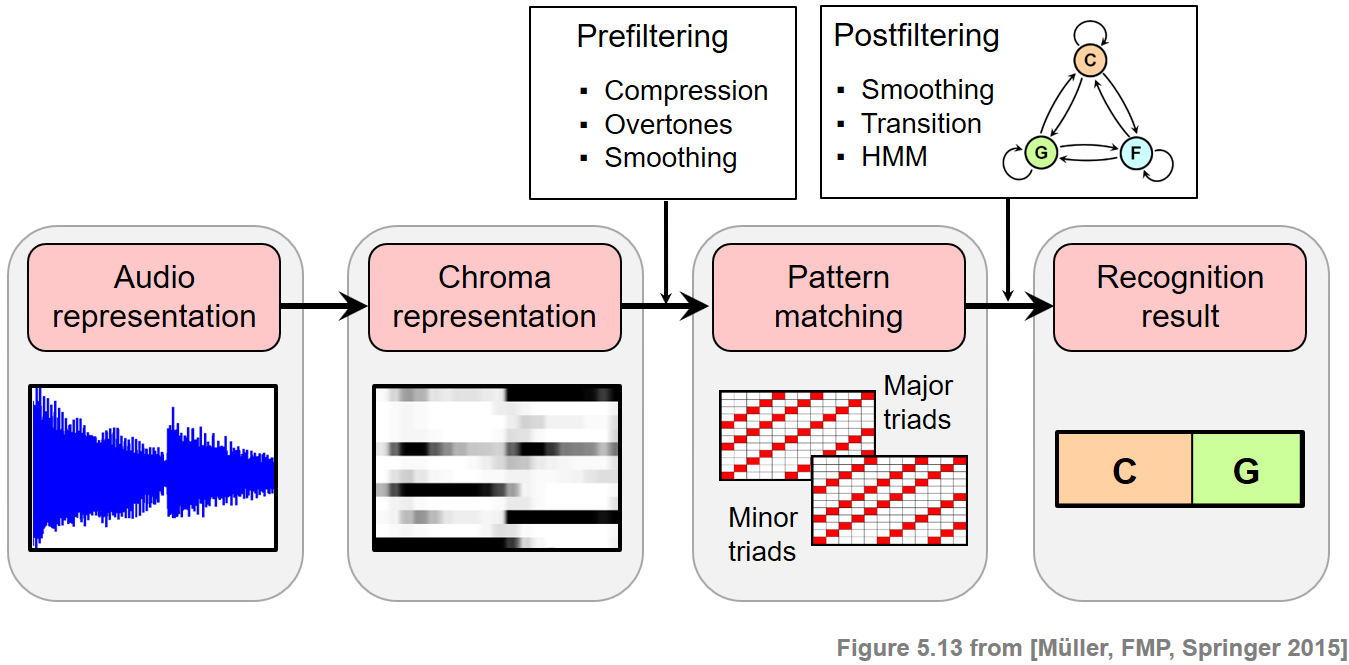

In [10]:
ipd.Image("../img/6.chord_recognition/FMP_C5_F13.png", width=700)


- 여기서는 기본적인 HMM 변형만 다루었지만, 여러가지 변형과 확장적인 HMM(e.g. 연속 HMMs, HMMs with specific state transition topologies)을 쓸 수도 있다. HMM은 모형 매개변수를 고정하는 대신 자동적으로 자유 매개변수를 학습시키는(e.g. Baum-Welch 알고리즘) 장점이 있다. 모델 매개변수를 수동으로 고정하는 대신 일반 HMM은 학습 예제를 기반으로 자유 매개변수를 자동으로 학습하는 것이다(예: [Baum-Welch 알고리즘] 사용).

- 참고: [Hidden Markov Models for Speech Recognition](https://dl.acm.org/doi/book/10.5555/575447) by Huang et al. (1990). 

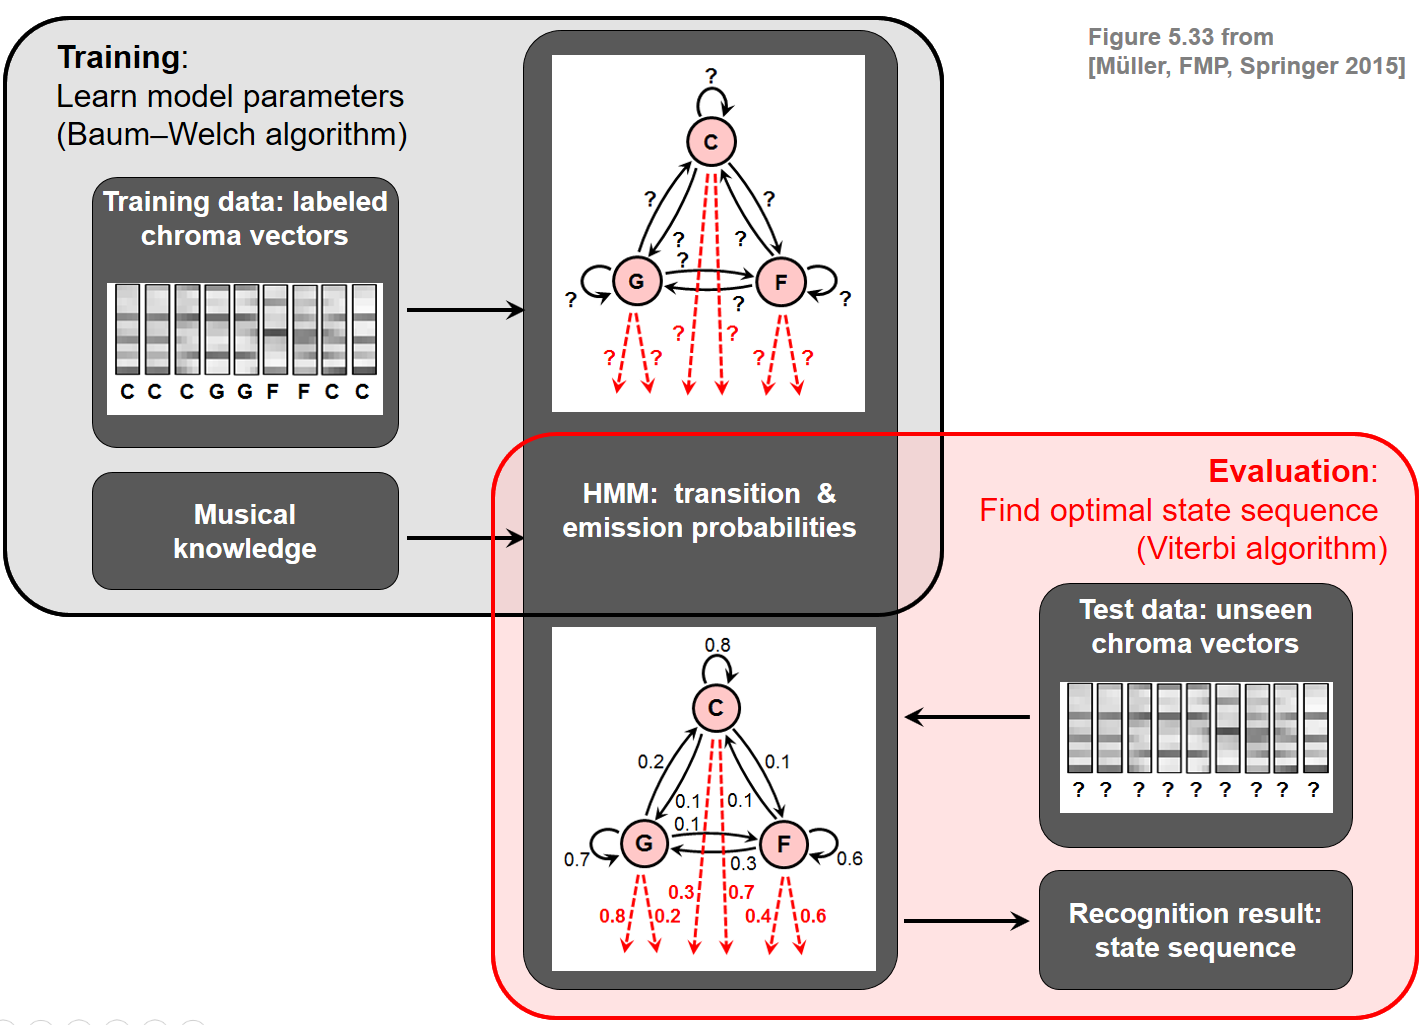

In [11]:
ipd.Image("../img/6.chord_recognition/FMP_C5_F33.png" , width=600)

---

출처: 

- https://www.audiolabs-erlangen.de/resources/MIR/FMP/C5/C5S3_HiddenMarkovModel.html
- https://www.audiolabs-erlangen.de/resources/MIR/FMP/C5/C5S3_Viterbi.html
- https://www.audiolabs-erlangen.de/resources/MIR/FMP/C5/C5S3_ChordRec_HMM.html
---

[구글 Colab 링크](https://colab.research.google.com/github/jo-cho/mir_kr/blob/main/Notebooks/6.%20Chord%20Recognition/6.3.HMM-Based_Chord_Recognition.ipynb)